# Fáza 2 IAU - Daniela Paľuchová 50%, Mark Bartalos 50% 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from datetime import datetime
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OneHotEncoder


In [3]:
products = pd.read_csv("data/product.csv", sep='\t')
sessions = pd.read_csv("data/session.csv", sep='\t')
users = pd.read_csv("data/user.csv", sep='\t')

Vyriešené chyby z predchádzajúcej fázy

In [4]:
users = users.drop_duplicates(subset='user_id', keep='first')
users['race'] = users['race'].fillna('unspecified')
users['birthdate'] = pd.to_datetime(users['birthdate'], errors='coerce')
sessions['ack']=sessions['ack'].astype(int)
duplikatne_riadky = sessions[sessions.duplicated()]
sessions.drop_duplicates(inplace=True)
sessions['session_start'] = pd.to_datetime(sessions['session_start'], errors='coerce')

In [5]:
products.head()

,code,location,store_name,product_ean
0,HR,Europe/Zagreb,Split,3618641987900
1,CN,Asia/Shanghai,Heyuan,890698872559
2,NL,Europe/Amsterdam,Barneveld,2447491624236
3,MX,America/Mexico_City,Tuxtla,2920947188549
4,US,America/New_York,Sun City Center,4869841703558


In [6]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14962 entries, 0 to 14961
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   code         14948 non-null  object
 1   location     14962 non-null  object
 2   store_name   14962 non-null  object
 3   product_ean  14962 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 467.7+ KB


In [7]:
sessions.head()

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,session_start,total_load_time,pct_click,...,session_id,pct_scroll_move_duration,ack,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click
0,33.93175,600,2.02433,47.57172,77.67966,50.06169,16.15405,2022-04-16 18:13:19,3.66109,15.21849,...,341891,17.64845,0,13.31028,15.50704,16.78128,safari,73.88232,93.50794,NaN
1,35.01962,768,2.73613,44.98978,40.38256,53.78582,16.44725,2022-09-07 09:34:07,3.06183,17.79744,...,1302699,16.90542,1,18.33657,15.76245,16.67535,firefox,36.27018,83.05534,15.63971
2,61.41151,800,2.30551,56.16179,29.32719,61.74431,16.28032,2022-08-01 19:22:50,4.30491,16.56530,...,1346090,20.42301,1,7.24767,15.94806,17.84916,opera,44.07316,212.16973,13.54653
3,44.86510,600,4.67376,51.02882,57.35852,44.10727,16.97307,2020-03-28 06:00:21,2.66177,14.10738,...,320000,19.13251,0,9.27093,17.21545,15.85436,edge,61.91555,62.13615,14.83673
4,61.66559,800,6.29241,33.35663,50.05876,36.03935,17.26692,2023-02-12 18:25:13,3.67287,19.04736,...,291366,13.65667,0,19.71573,17.01892,16.65385,chrome,21.36066,157.60814,15.17088


In [8]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10962 entries, 0 to 11093
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   pct_wild_mouse                  10951 non-null  float64       
 1   screen_height                   10962 non-null  object        
 2   pct_input                       10951 non-null  float64       
 3   pct_scrandom                    10951 non-null  float64       
 4   pct_scroll_move                 10951 non-null  float64       
 5   pct_click_product_info          10951 non-null  float64       
 6   wild_mouse_duration             10951 non-null  float64       
 7   session_start                   10962 non-null  datetime64[ns]
 8   total_load_time                 10962 non-null  float64       
 9   pct_click                       10951 non-null  float64       
 10  screen_width                    10962 non-null  object        
 11  pct_dou

In [9]:
users.head()

,username,residence,current_location,name,mail,job,sex,race,address,birthdate,user_id
0,gabrieladas-neves,NaN,"(Decimal('-37.802134'), Decimal('79.453092'))",Sabrina da Luz,xda-cunha@yahoo.com.br,Engenheiro aeronáutico,NaN,unspecified,"Condomínio de Silva, 16\nNovo Ouro Preto\n6891...",NaT,640
1,ferreirajulia,NaN,"(Decimal('4.633756'), Decimal('102.063245'))",Maria Vitória Mendes,catarinada-conceicao@gmail.com,Mãe social,F,black,"Campo Eloah Ribeiro, 66\nEstrela Do Oriente\n2...",1946-06-27,1222
2,isadora80,NaN,"(Decimal('80.9854585'), Decimal('135.043616'))",Isabella Nascimento,maria-sophiasouza@ig.com.br,NaN,NaN,unspecified,Viela da Luz\nConjunto Santa Maria\n92354128 A...,1940-12-01,298
3,adriana04,NaN,"(Decimal('67.6271835'), Decimal('-41.336778'))",Daria Boldù,ngaleati@alice.it,NaN,NaN,unspecified,"Vicolo Sophia, 452 Piano 7\n26843, Meleti (LO)",1958-02-01,316
4,kellygreg,NaN,"(Decimal('39.336945'), Decimal('120.879401'))",Sandra Jenkins,danieljordan@yahoo.com,Fine artist,NaN,unspecified,31740 Maria Stravenue Apt. 240\nLake Rodneyfur...,1997-05-26,1992


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1594 entries, 0 to 2536
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   username          1594 non-null   object        
 1   residence         553 non-null    object        
 2   current_location  1509 non-null   object        
 3   name              1594 non-null   object        
 4   mail              1594 non-null   object        
 5   job               635 non-null    object        
 6   sex               777 non-null    object        
 7   race              1594 non-null   object        
 8   address           1354 non-null   object        
 9   birthdate         903 non-null    datetime64[ns]
 10  user_id           1594 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 149.4+ KB


Po skúšaní spojiť session s product som prisšla k zisteniu, že product_ean sa nezhodujú, takže sa tie dva datasety nedajú spojiť. Nevidím žiadne logické riešenie ako by sa to dalo napraviť. Takže budem spájať a následne pracovať iba s users a sessions.

In [11]:
merged_data = pd.merge(sessions, users, on='user_id', how='left')
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10962 entries, 0 to 10961
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   pct_wild_mouse                  10951 non-null  float64       
 1   screen_height                   10962 non-null  object        
 2   pct_input                       10951 non-null  float64       
 3   pct_scrandom                    10951 non-null  float64       
 4   pct_scroll_move                 10951 non-null  float64       
 5   pct_click_product_info          10951 non-null  float64       
 6   wild_mouse_duration             10951 non-null  float64       
 7   session_start                   10962 non-null  datetime64[ns]
 8   total_load_time                 10962 non-null  float64       
 9   pct_click                       10951 non-null  float64       
 10  screen_width                    10962 non-null  object        
 11  pc

*Ako prvé idem vymatať stlpce, ktoré sú mi zbytočné*</br>
Vyrobila som si stlpec age (nahradila som aj chýbajúce hodnoty priemerom) pomocou stlpca birthday, ktorý následne budem vymazávať

In [12]:
merged_data['age'] = ((datetime.now() - merged_data['birthdate']).dt.days / 365.25)
merged_data['age'] = merged_data['age'].round()
mean_age = merged_data['age'].mean()
merged_data['age'].fillna(mean_age, inplace=True)
merged_data['age'] = merged_data['age'].round().astype(int)

merged_data.head()

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,session_start,total_load_time,pct_click,...,residence,current_location,name,mail,job,sex,race,address,birthdate,age
0,33.93175,600,2.02433,47.57172,77.67966,50.06169,16.15405,2022-04-16 18:13:19,3.66109,15.21849,...,NaN,"(Decimal('65.429204'), Decimal('27.147097'))",Rebeca Silva,danielsouza@bol.com.br,Lubrificador de máquinas,NaN,unspecified,"Sítio da Luz, 777\nCarmo\n54487013 Silveira Ve...",1988-07-17,35
1,35.01962,768,2.73613,44.98978,40.38256,53.78582,16.44725,2022-09-07 09:34:07,3.06183,17.79744,...,NaN,"(Decimal('-65.9975475'), Decimal('-33.607602'))",Daria Boccaccio,francescapiane@alice.it,Sports development officer,F,unspecified,"Stretto Cammarata, 48 Appartamento 9\n44122, F...",2016-12-07,7
2,61.41151,800,2.30551,56.16179,29.32719,61.74431,16.28032,2022-08-01 19:22:50,4.30491,16.56530,...,auch Schlauchinallee 0/2\n71393 Angermünde,"(Decimal('53.467912'), Decimal('6.845211'))",Marisa Trubin,filiz70@hotmail.de,NaN,NaN,unspecified,Matthäistraße 376\n50173 Merseburg,1939-09-18,84
3,44.86510,600,4.67376,51.02882,57.35852,44.10727,16.97307,2020-03-28 06:00:21,2.66177,14.10738,...,NaN,"(Decimal('59.408055'), Decimal('129.747870'))",Igor Barbosa,rezendesofia@uol.com.br,NaN,M,unspecified,"Trevo de Gonçalves, 246\nLuxemburgo\n79216440 ...",NaT,60
4,61.66559,800,6.29241,33.35663,50.05876,36.03935,17.26692,2023-02-12 18:25:13,3.67287,19.04736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,60


In [13]:
if 'username' in merged_data.columns:
    merged_data.drop('username', axis='columns', inplace=True)
    print("vymazanie username")
if 'residence' in merged_data.columns:
    merged_data.drop('residence', axis='columns', inplace=True)
    print("vymazanie residence")
if 'current_location' in merged_data.columns:
    merged_data.drop('current_location', axis='columns', inplace=True)
    print("vymazanie current_location")
if 'name' in merged_data.columns:
    merged_data.drop('name', axis='columns', inplace=True)
    print("vymazanie name")
if 'mail' in merged_data.columns:
    merged_data.drop('mail', axis='columns', inplace=True)
    print("vymazanie mail")
if 'address' in merged_data.columns:
    merged_data.drop('address', axis='columns', inplace=True)
    print("vymazanie address")
if 'birthdate' in merged_data.columns:
    merged_data.drop('birthdate', axis='columns', inplace=True)
    print("vymazanie birthdate")
if 'session_start' in merged_data.columns:
    merged_data.drop('session_start', axis='columns', inplace=True)
    print("vymazanie session_start")
if 'sex' in merged_data.columns:
    merged_data.drop('sex', axis='columns', inplace=True)
    print("vymazanie sex")
merged_data.head()

vymazanie username
vymazanie residence
vymazanie current_location
vymazanie name
vymazanie mail
vymazanie address
vymazanie birthdate
vymazanie session_start
vymazanie sex


,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,total_load_time,pct_click,screen_width,...,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click,job,race,age
0,33.93175,600,2.02433,47.57172,77.67966,50.06169,16.15405,3.66109,15.21849,1366,...,13.31028,15.50704,16.78128,safari,73.88232,93.50794,NaN,Lubrificador de máquinas,unspecified,35
1,35.01962,768,2.73613,44.98978,40.38256,53.78582,16.44725,3.06183,17.79744,1280,...,18.33657,15.76245,16.67535,firefox,36.27018,83.05534,15.63971,Sports development officer,unspecified,7
2,61.41151,800,2.30551,56.16179,29.32719,61.74431,16.28032,4.30491,16.56530,1280,...,7.24767,15.94806,17.84916,opera,44.07316,212.16973,13.54653,NaN,unspecified,84
3,44.86510,600,4.67376,51.02882,57.35852,44.10727,16.97307,2.66177,14.10738,1920,...,9.27093,17.21545,15.85436,edge,61.91555,62.13615,14.83673,NaN,unspecified,60
4,61.66559,800,6.29241,33.35663,50.05876,36.03935,17.26692,3.67287,19.04736,1024,...,19.71573,17.01892,16.65385,chrome,21.36066,157.60814,15.17088,NaN,NaN,60


Vymazali sme hodnoty, ktoré su pre každého usera jedinečné a teda nám nič nepovedia o ack, teda username, residence, current_location, name, mail, address, birthdate a session_start. Dalej sme vymazali aj atribút sex, pretože má okolo 60% NaN hodnot a analyzovať ack na základe tohto atribútu by teda nebolo presné._start

In [14]:
merged_data['race'] = merged_data['race'].fillna('unspecified')
merged_data['job'] = merged_data['job'].fillna('unspecified')
merged_data.head()

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,total_load_time,pct_click,screen_width,...,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click,job,race,age
0,33.93175,600,2.02433,47.57172,77.67966,50.06169,16.15405,3.66109,15.21849,1366,...,13.31028,15.50704,16.78128,safari,73.88232,93.50794,NaN,Lubrificador de máquinas,unspecified,35
1,35.01962,768,2.73613,44.98978,40.38256,53.78582,16.44725,3.06183,17.79744,1280,...,18.33657,15.76245,16.67535,firefox,36.27018,83.05534,15.63971,Sports development officer,unspecified,7
2,61.41151,800,2.30551,56.16179,29.32719,61.74431,16.28032,4.30491,16.56530,1280,...,7.24767,15.94806,17.84916,opera,44.07316,212.16973,13.54653,unspecified,unspecified,84
3,44.86510,600,4.67376,51.02882,57.35852,44.10727,16.97307,2.66177,14.10738,1920,...,9.27093,17.21545,15.85436,edge,61.91555,62.13615,14.83673,unspecified,unspecified,60
4,61.66559,800,6.29241,33.35663,50.05876,36.03935,17.26692,3.67287,19.04736,1024,...,19.71573,17.01892,16.65385,chrome,21.36066,157.60814,15.17088,unspecified,unspecified,60


Doplnenie chýbajúcich hodnôt do objektových atribútov</br>
Race má už v pôvodných dátach hodnotu 'unspecified' a v tomto kontexte je to isté ako NaN, tak všetky NaN hodnoty tým nahradíme. V atribúte jobs sa nachádza veľké množstvo NaN hodnôt a veľa rozličných druhov prác, takže by nebolo logické to nahradzovať napríklad pomerom prác, takže použijeme znova označenie 'unspecified'. Ziaden pocet NaN v spomýnaných atribútov vyššie nebol natoľko nízky, aby sme si ich mohli dovoliť vymazať. Ďalšie objektové atribúty nemajú NaN hodnoty 

In [15]:
ce_ordinal = ce.OrdinalEncoder(cols=['race'])
merged_data= ce_ordinal.fit_transform(merged_data)
ce_ordinal = ce.OrdinalEncoder(cols=['job'])
merged_data= ce_ordinal.fit_transform(merged_data)
ce_ordinal = ce.OrdinalEncoder(cols=['browser_name'])
merged_data= ce_ordinal.fit_transform(merged_data)
ce_ordinal = ce.OrdinalEncoder(cols=['screen_height'])
merged_data= ce_ordinal.fit_transform(merged_data)
ce_ordinal = ce.OrdinalEncoder(cols=['screen_width'])
merged_data= ce_ordinal.fit_transform(merged_data)
merged_data.head()

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,total_load_time,pct_click,screen_width,...,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click,job,race,age
0,33.93175,1,2.02433,47.57172,77.67966,50.06169,16.15405,3.66109,15.21849,1,...,13.31028,15.50704,16.78128,1,73.88232,93.50794,NaN,1,1,35
1,35.01962,2,2.73613,44.98978,40.38256,53.78582,16.44725,3.06183,17.79744,2,...,18.33657,15.76245,16.67535,2,36.27018,83.05534,15.63971,2,1,7
2,61.41151,3,2.30551,56.16179,29.32719,61.74431,16.28032,4.30491,16.56530,2,...,7.24767,15.94806,17.84916,3,44.07316,212.16973,13.54653,3,1,84
3,44.86510,1,4.67376,51.02882,57.35852,44.10727,16.97307,2.66177,14.10738,3,...,9.27093,17.21545,15.85436,4,61.91555,62.13615,14.83673,3,1,60
4,61.66559,3,6.29241,33.35663,50.05876,36.03935,17.26692,3.67287,19.04736,4,...,19.71573,17.01892,16.65385,5,21.36066,157.60814,15.17088,3,1,60


Následne objectové atribúty zmeníme na číselne pomocou Ordinal Encoding

In [16]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10962 entries, 0 to 10961
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_wild_mouse                  10951 non-null  float64
 1   screen_height                   10962 non-null  int64  
 2   pct_input                       10951 non-null  float64
 3   pct_scrandom                    10951 non-null  float64
 4   pct_scroll_move                 10951 non-null  float64
 5   pct_click_product_info          10951 non-null  float64
 6   wild_mouse_duration             10951 non-null  float64
 7   total_load_time                 10962 non-null  float64
 8   pct_click                       10951 non-null  float64
 9   screen_width                    10962 non-null  int64  
 10  pct_doubleclick                 10951 non-null  float64
 11  product_ean                     10962 non-null  int64  
 12  pct_mouse_move                  

In [17]:
def deleteNaN(merged_data):
    for column in merged_data.columns:
        number_NaN=merged_data[column].isna().sum()
        if 0<number_NaN:
            merged_data = merged_data.dropna(subset=[column])
    return merged_data

In [18]:
def replaceNaNmean(merged_data):
    for column in merged_data.columns:
        number_NaN=merged_data[column].isna().sum()
        if 0<number_NaN:
           merged_data[column].fillna(merged_data[column].mean(), inplace=True)
    return merged_data

In [19]:
def replaceNaNmedian(merged_data):
    for column in merged_data.columns:
        number_NaN=merged_data[column].isna().sum()
        if 0<number_NaN:
           merged_data[column].fillna(merged_data[column].median(), inplace=True)
    return merged_data

In [20]:
#merged_data=deleteNaN(merged_data)
#merged_data=replaceNaNmean(merged_data)
merged_data=replaceNaNmedian(merged_data)

Vytvorili sme funkcie na vyriešenie NaN hodnôt. Môžeme si vybrať, či chceme ich vymazať, nahradiť priemerom alebo medianom. 

In [21]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10962 entries, 0 to 10961
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_wild_mouse                  10962 non-null  float64
 1   screen_height                   10962 non-null  int64  
 2   pct_input                       10962 non-null  float64
 3   pct_scrandom                    10962 non-null  float64
 4   pct_scroll_move                 10962 non-null  float64
 5   pct_click_product_info          10962 non-null  float64
 6   wild_mouse_duration             10962 non-null  float64
 7   total_load_time                 10962 non-null  float64
 8   pct_click                       10962 non-null  float64
 9   screen_width                    10962 non-null  int64  
 10  pct_doubleclick                 10962 non-null  float64
 11  product_ean                     10962 non-null  int64  
 12  pct_mouse_move                  

/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

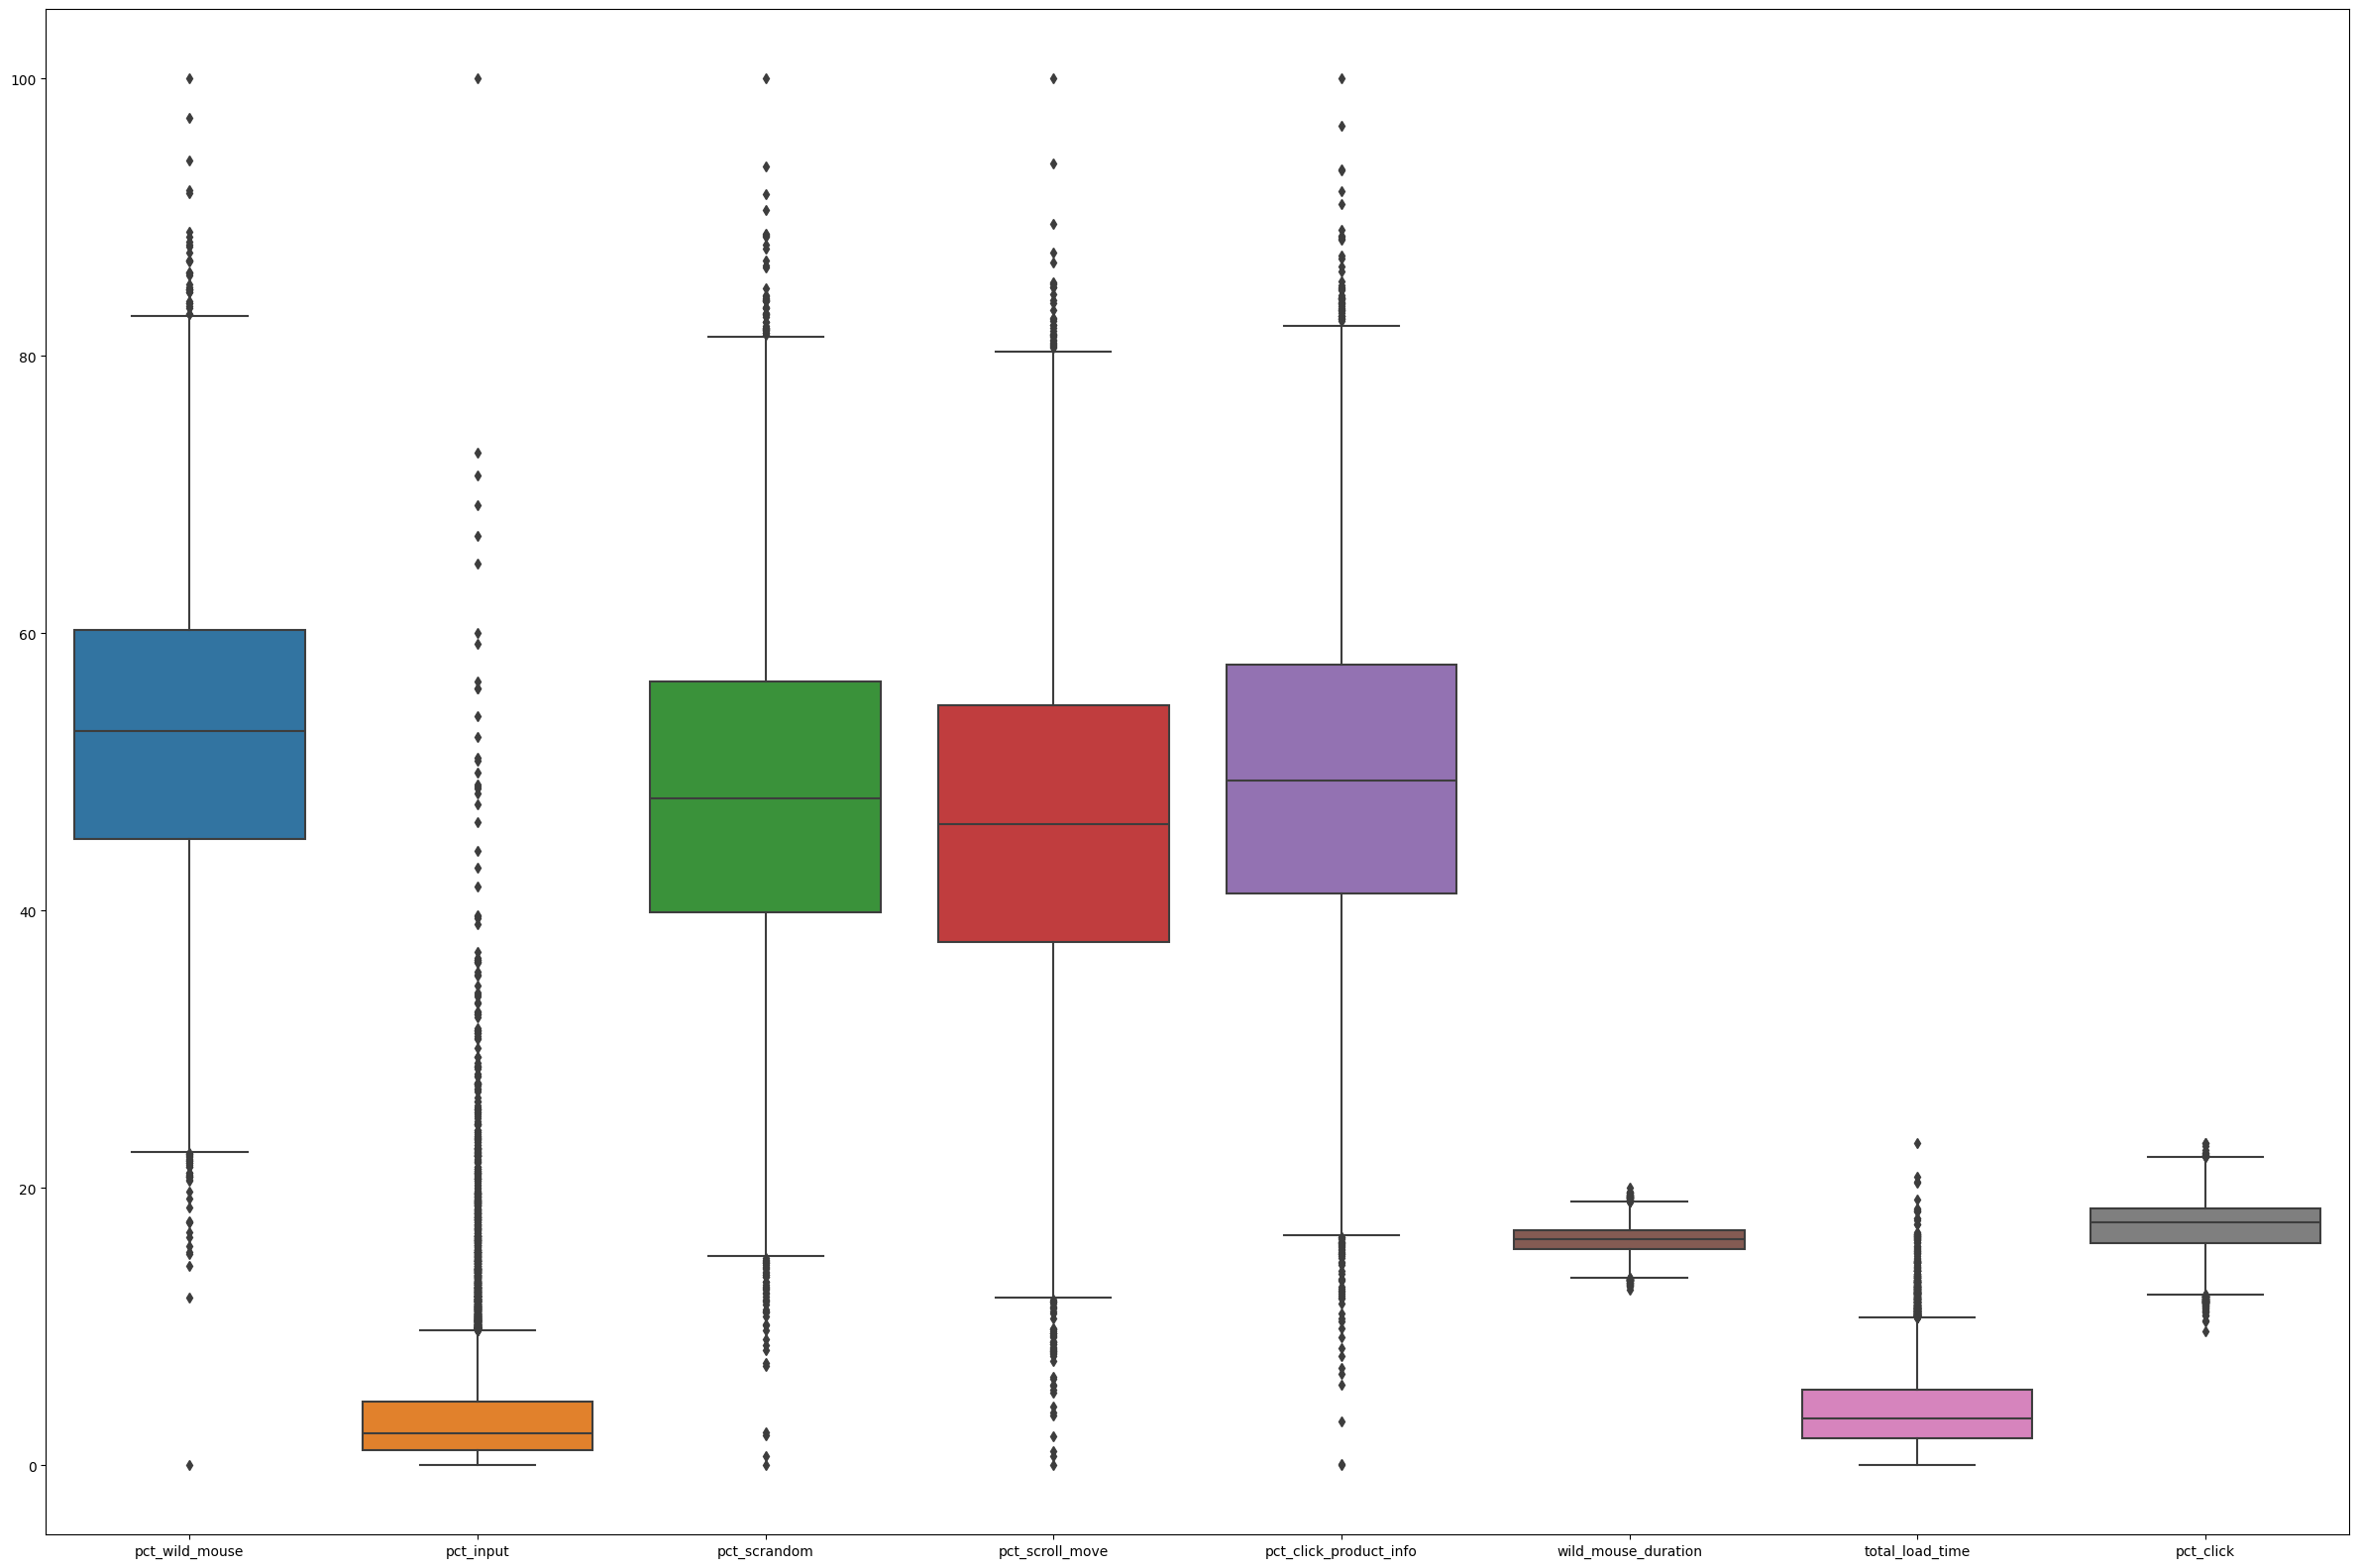

In [22]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.boxplot(data=merged_data[['pct_wild_mouse', 'pct_input', 'pct_scrandom', 'pct_scroll_move', 'pct_click_product_info', 'wild_mouse_duration', 'total_load_time', 'pct_click']])
plt.show()

/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

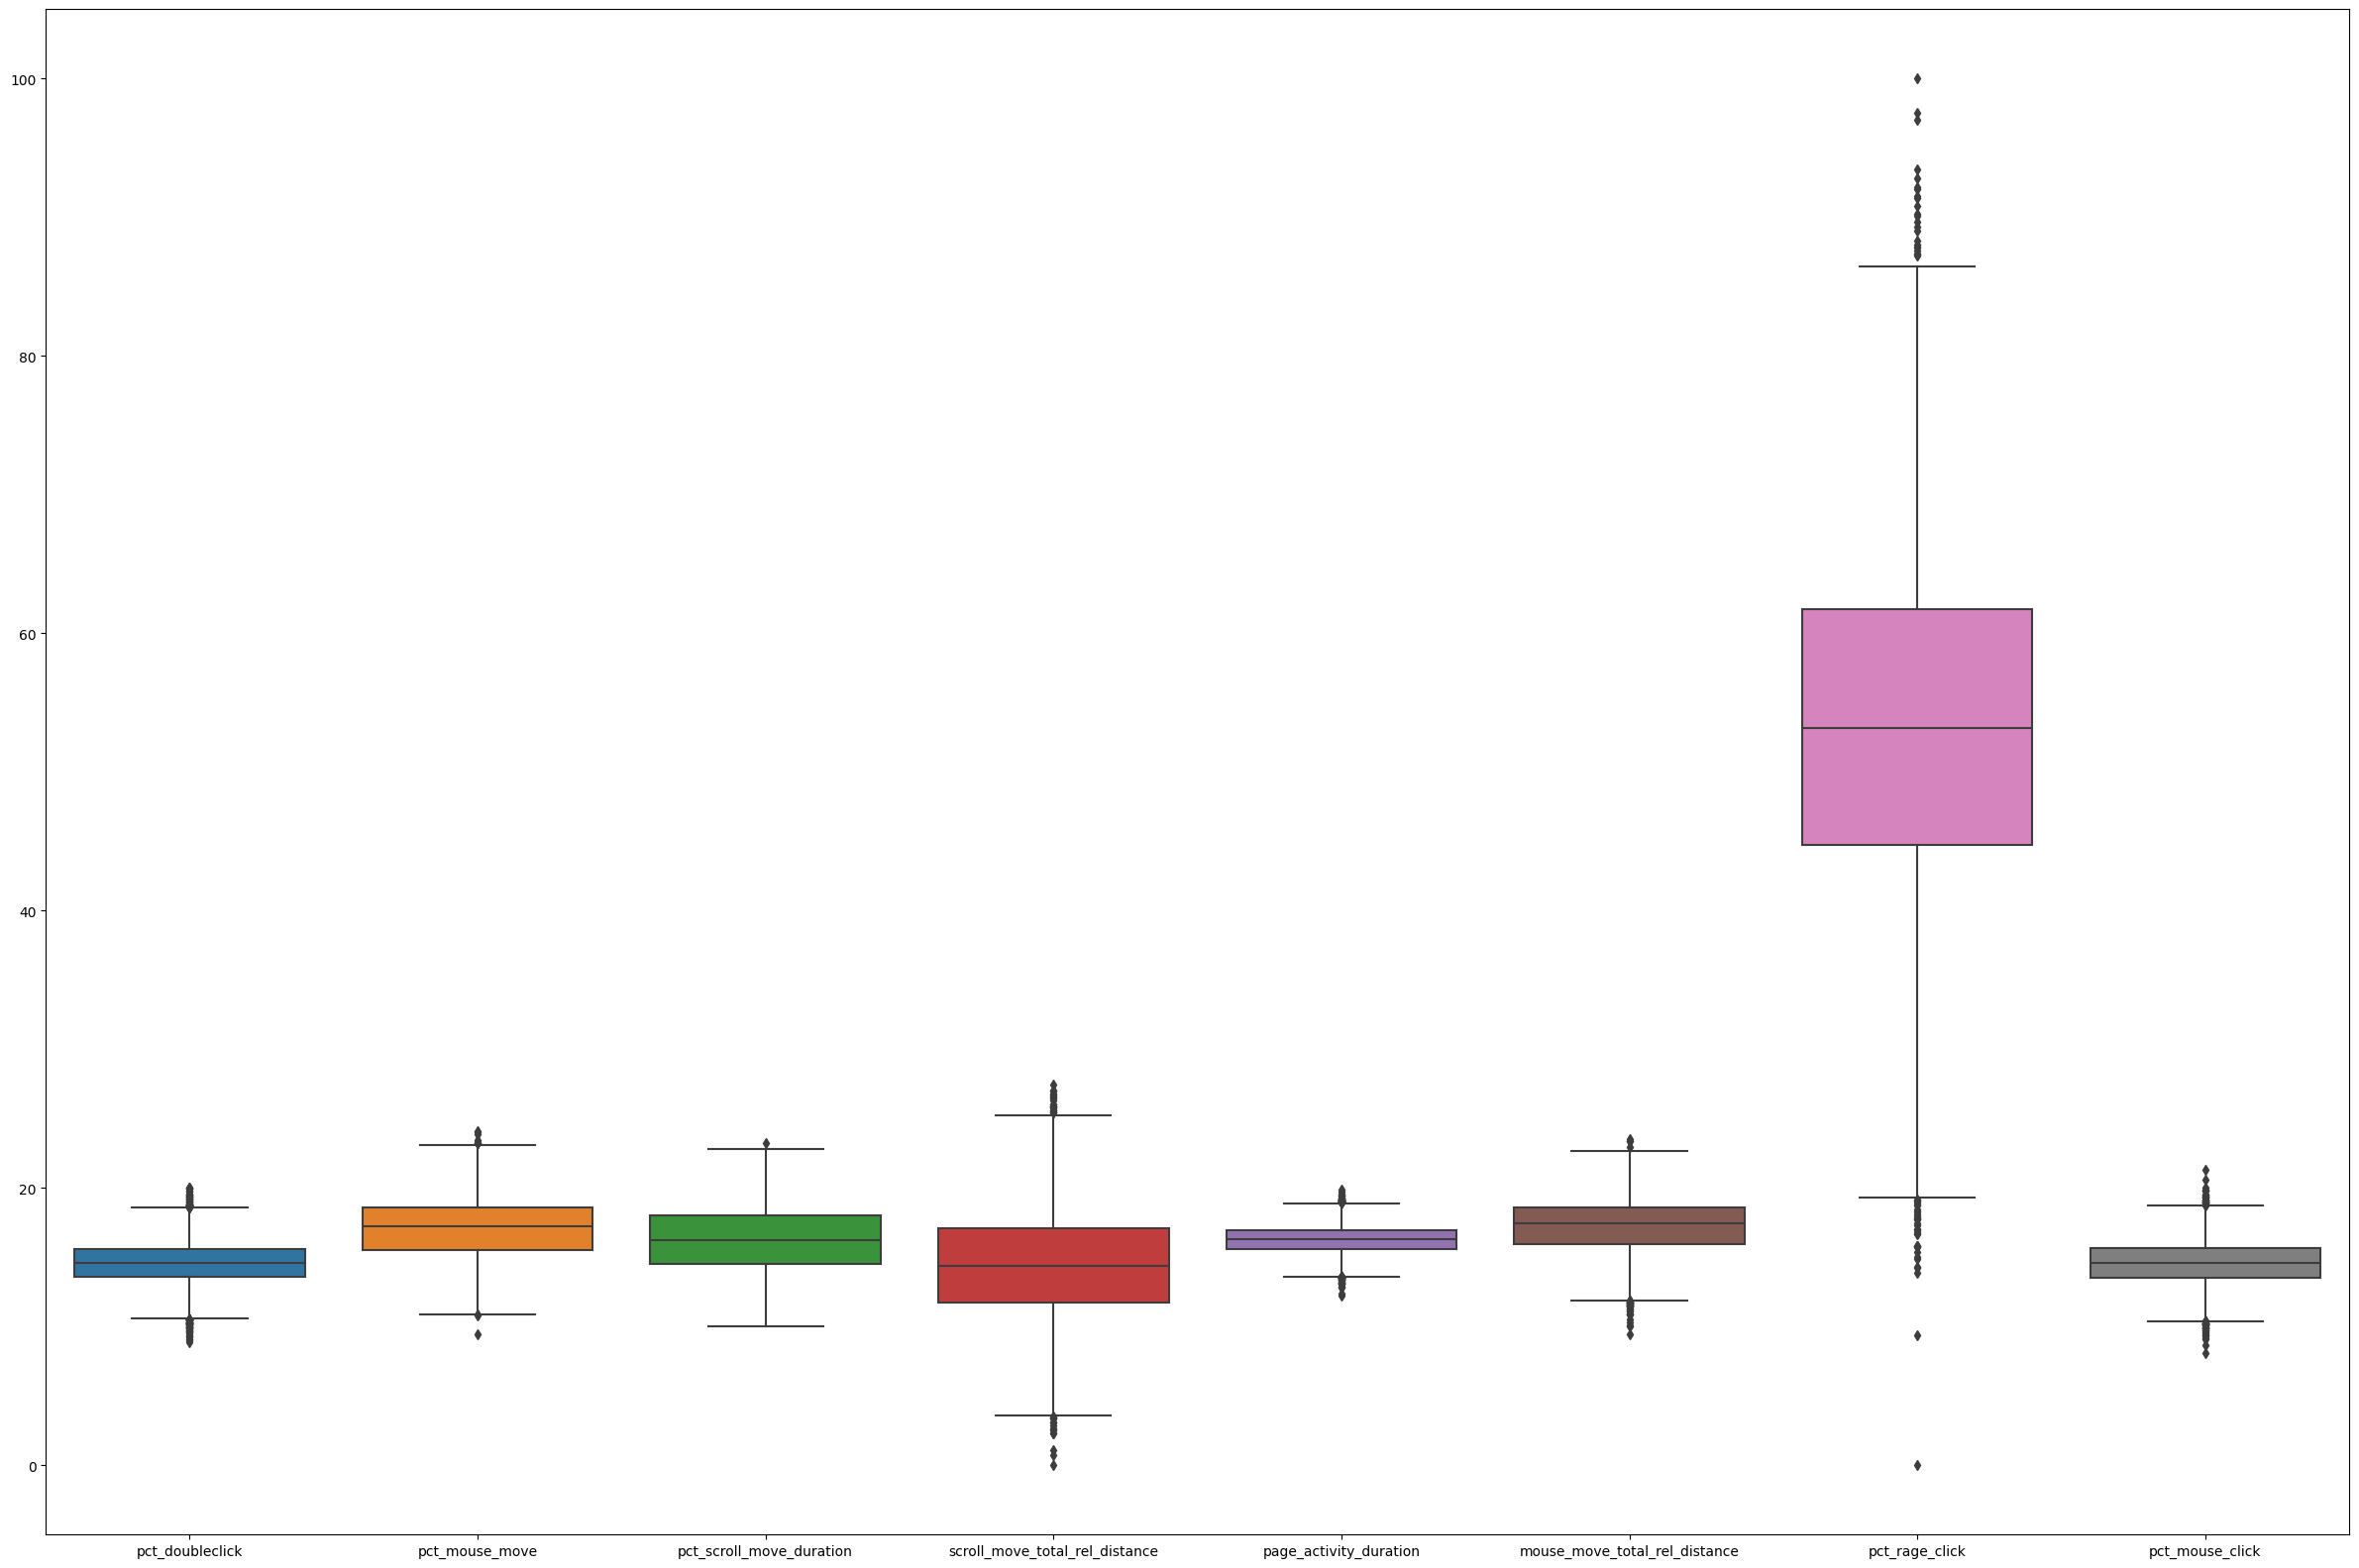

In [23]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.boxplot(data=merged_data[['pct_doubleclick', 'pct_mouse_move', 'pct_scroll_move_duration', 'scroll_move_total_rel_distance', 'page_activity_duration', 'mouse_move_total_rel_distance', 'pct_rage_click', 'pct_mouse_click']])
plt.show()

Na grafoch môžeme vidieť, že atribúty majú outlierov. Niektoré viac, niektoré menej. V grafe som obsiahla všetky atribúty, ktorých atribúty by bolo potrebné ošetriť na outlierov (ešte session duration, ale to som nedávala do grafu, lebo má veľké hodnoty oproti ostatným atribútom a nie je dobre vidieť potom ostatné)


In [24]:
#Funkcia prevzatá zo vzorových notebookov
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [25]:
def delete_outliers(merged_data):
    count=0
    pocet_zaznamov_na_zaciatku=merged_data.shape[0]
    for column in merged_data[['pct_doubleclick', 'pct_mouse_move', 'pct_scroll_move_duration', 'scroll_move_total_rel_distance', 'page_activity_duration', 'mouse_move_total_rel_distance', 'pct_rage_click', 'pct_mouse_click', 'pct_wild_mouse', 'pct_input', 'pct_scrandom', 'pct_scroll_move', 'pct_click_product_info', 'wild_mouse_duration', 'total_load_time', 'pct_click', 'session_duration']]:
        outliers = identify_outliers(merged_data[column])
        count+=outliers.count()
        merged_data=merged_data.drop(outliers.index)

    print(f'Počet vychýlených hodnôt je {count}')
    print(f'Percento zaznamov, ktore ostali v percentach: {merged_data.shape[0]*100/pocet_zaznamov_na_zaciatku}')
    return merged_data

In [26]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10962 entries, 0 to 10961
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_wild_mouse                  10962 non-null  float64
 1   screen_height                   10962 non-null  int64  
 2   pct_input                       10962 non-null  float64
 3   pct_scrandom                    10962 non-null  float64
 4   pct_scroll_move                 10962 non-null  float64
 5   pct_click_product_info          10962 non-null  float64
 6   wild_mouse_duration             10962 non-null  float64
 7   total_load_time                 10962 non-null  float64
 8   pct_click                       10962 non-null  float64
 9   screen_width                    10962 non-null  int64  
 10  pct_doubleclick                 10962 non-null  float64
 11  product_ean                     10962 non-null  int64  
 12  pct_mouse_move                  

In [27]:

merged_data = delete_outliers(merged_data)
merged_data.info()

Počet vychýlených hodnôt je 2014
Percento zaznamov, ktore ostali v percentach: 81.6274402481299
<class 'pandas.core.frame.DataFrame'>
Index: 8948 entries, 0 to 10961
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_wild_mouse                  8948 non-null   float64
 1   screen_height                   8948 non-null   int64  
 2   pct_input                       8948 non-null   float64
 3   pct_scrandom                    8948 non-null   float64
 4   pct_scroll_move                 8948 non-null   float64
 5   pct_click_product_info          8948 non-null   float64
 6   wild_mouse_duration             8948 non-null   float64
 7   total_load_time                 8948 non-null   float64
 8   pct_click                       8948 non-null   float64
 9   screen_width                    8948 non-null   int64  
 10  pct_doubleclick                 8948 non-null   float64
 11  pro

Vymazanie outlierov, zistili sme, že skoro 20% dát sme stratili

In [28]:
def delete_outliers_quantile(merged_data):
    count=0
    for column in merged_data[['pct_doubleclick', 'pct_mouse_move', 'pct_scroll_move_duration', 'scroll_move_total_rel_distance', 'page_activity_duration', 'mouse_move_total_rel_distance', 'pct_rage_click', 'pct_mouse_click', 'pct_wild_mouse', 'pct_input', 'pct_scrandom', 'pct_scroll_move', 'pct_click_product_info', 'wild_mouse_duration', 'total_load_time', 'pct_click', 'session_duration']]:
        outliers = identify_outliers(merged_data[column])
        lower_q = merged_data[column].quantile(0.05)
        uper_q = merged_data[column].quantile(0.95)
        count+=outliers.count()
        merged_data[column] = merged_data[column].clip(lower_q, uper_q)
        
    print(f'Počet zmenenych hodnôt je {count}')
    return merged_data



In [29]:
#merged_data = delete_outliers_quantile(merged_data)
#merged_data.info()

Alternatíva pre outlierov je, že ich nahradím hraničnými hodnotami, teda quantilom 0.05 alebo 0.95

# 2. Predspracovanie dat

Údaje rozdelíme do 2 rôznych súborov údajov, jedna bude určená na trénovanie a druhá časť bude slúžiť na testovanie predpokladaných výsledkov. Tréningová časť bude tvoriť 80 % údajov a testovacia časť bude tvoriť 20 % kompletných údajov.

In [30]:
features = merged_data.drop('ack', axis=1)
target = merged_data['ack']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,total_load_time,pct_click,screen_width,...,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click,job,race,age
9326,57.65601,5,1.16775,31.05366,75.03575,40.50160,15.62633,1.93104,14.51268,5,...,9.90963,15.77853,13.28226,3,23.49009,64.32872,11.82479,3,1,84
6986,53.20554,1,4.03700,42.57398,66.77075,28.88212,16.82874,5.17281,18.12052,2,...,13.72969,17.33340,17.15487,5,43.50684,165.46769,15.66504,3,1,60
3621,32.08738,2,1.12728,45.43745,52.70110,34.58205,15.59301,5.03297,18.33731,2,...,13.87142,15.33240,19.53838,4,52.84745,50.53015,13.69734,120,1,12
3637,59.44242,4,1.22600,42.07027,27.92109,27.66239,15.67245,5.70022,17.96591,7,...,15.78900,16.64294,18.89060,2,49.14594,186.58193,14.76433,3,1,60
9865,79.27181,5,0.68271,76.89111,61.08636,22.03654,15.12626,10.24121,20.48074,3,...,17.32169,16.81626,19.61759,4,32.02144,200.62330,16.36232,3,1,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,37.69758,5,6.67999,35.91832,36.30834,45.42789,17.32608,3.63522,19.52320,6,...,15.92570,16.15766,18.51539,5,55.63218,112.72287,14.79973,3,1,60
6369,47.32132,3,5.07519,35.73671,55.40893,62.39464,17.05438,0.94554,17.66598,2,...,14.19886,15.58098,19.56023,4,45.32908,184.86381,15.03829,3,1,60
6603,65.31653,6,0.45117,63.27280,53.17940,54.45418,14.75556,3.77690,17.53160,4,...,11.32240,15.53329,18.24384,4,73.10340,165.81022,10.77610,3,1,60
1057,78.75737,7,0.48053,45.92923,50.20358,49.03628,14.81084,2.30610,13.80669,3,...,13.23998,16.58841,13.74976,5,56.71765,84.42132,15.73600,3,1,91


### Encoding

Všetky užitočné textové stĺpce boli zakódované v predchádzajúcej časti pomocou ordinálneho kódovania, kde boli rôzne kategórie textu zakódované do čísel, pričom každej kategórii bolo priradené jedinečné číslo.

### Škálovanie


Údaje normalizujeme pomocou MinMaxScaler. Používame MinMaxScaler, pretože tento scaler poskytuje rovnomerné škálovanie a zaisťuje, že žiadna jediná funkcia nedominuje modelu kvôli jeho mierke. Tiež zachováva vzťahy medzi pôvodnými dátovými bodmi.

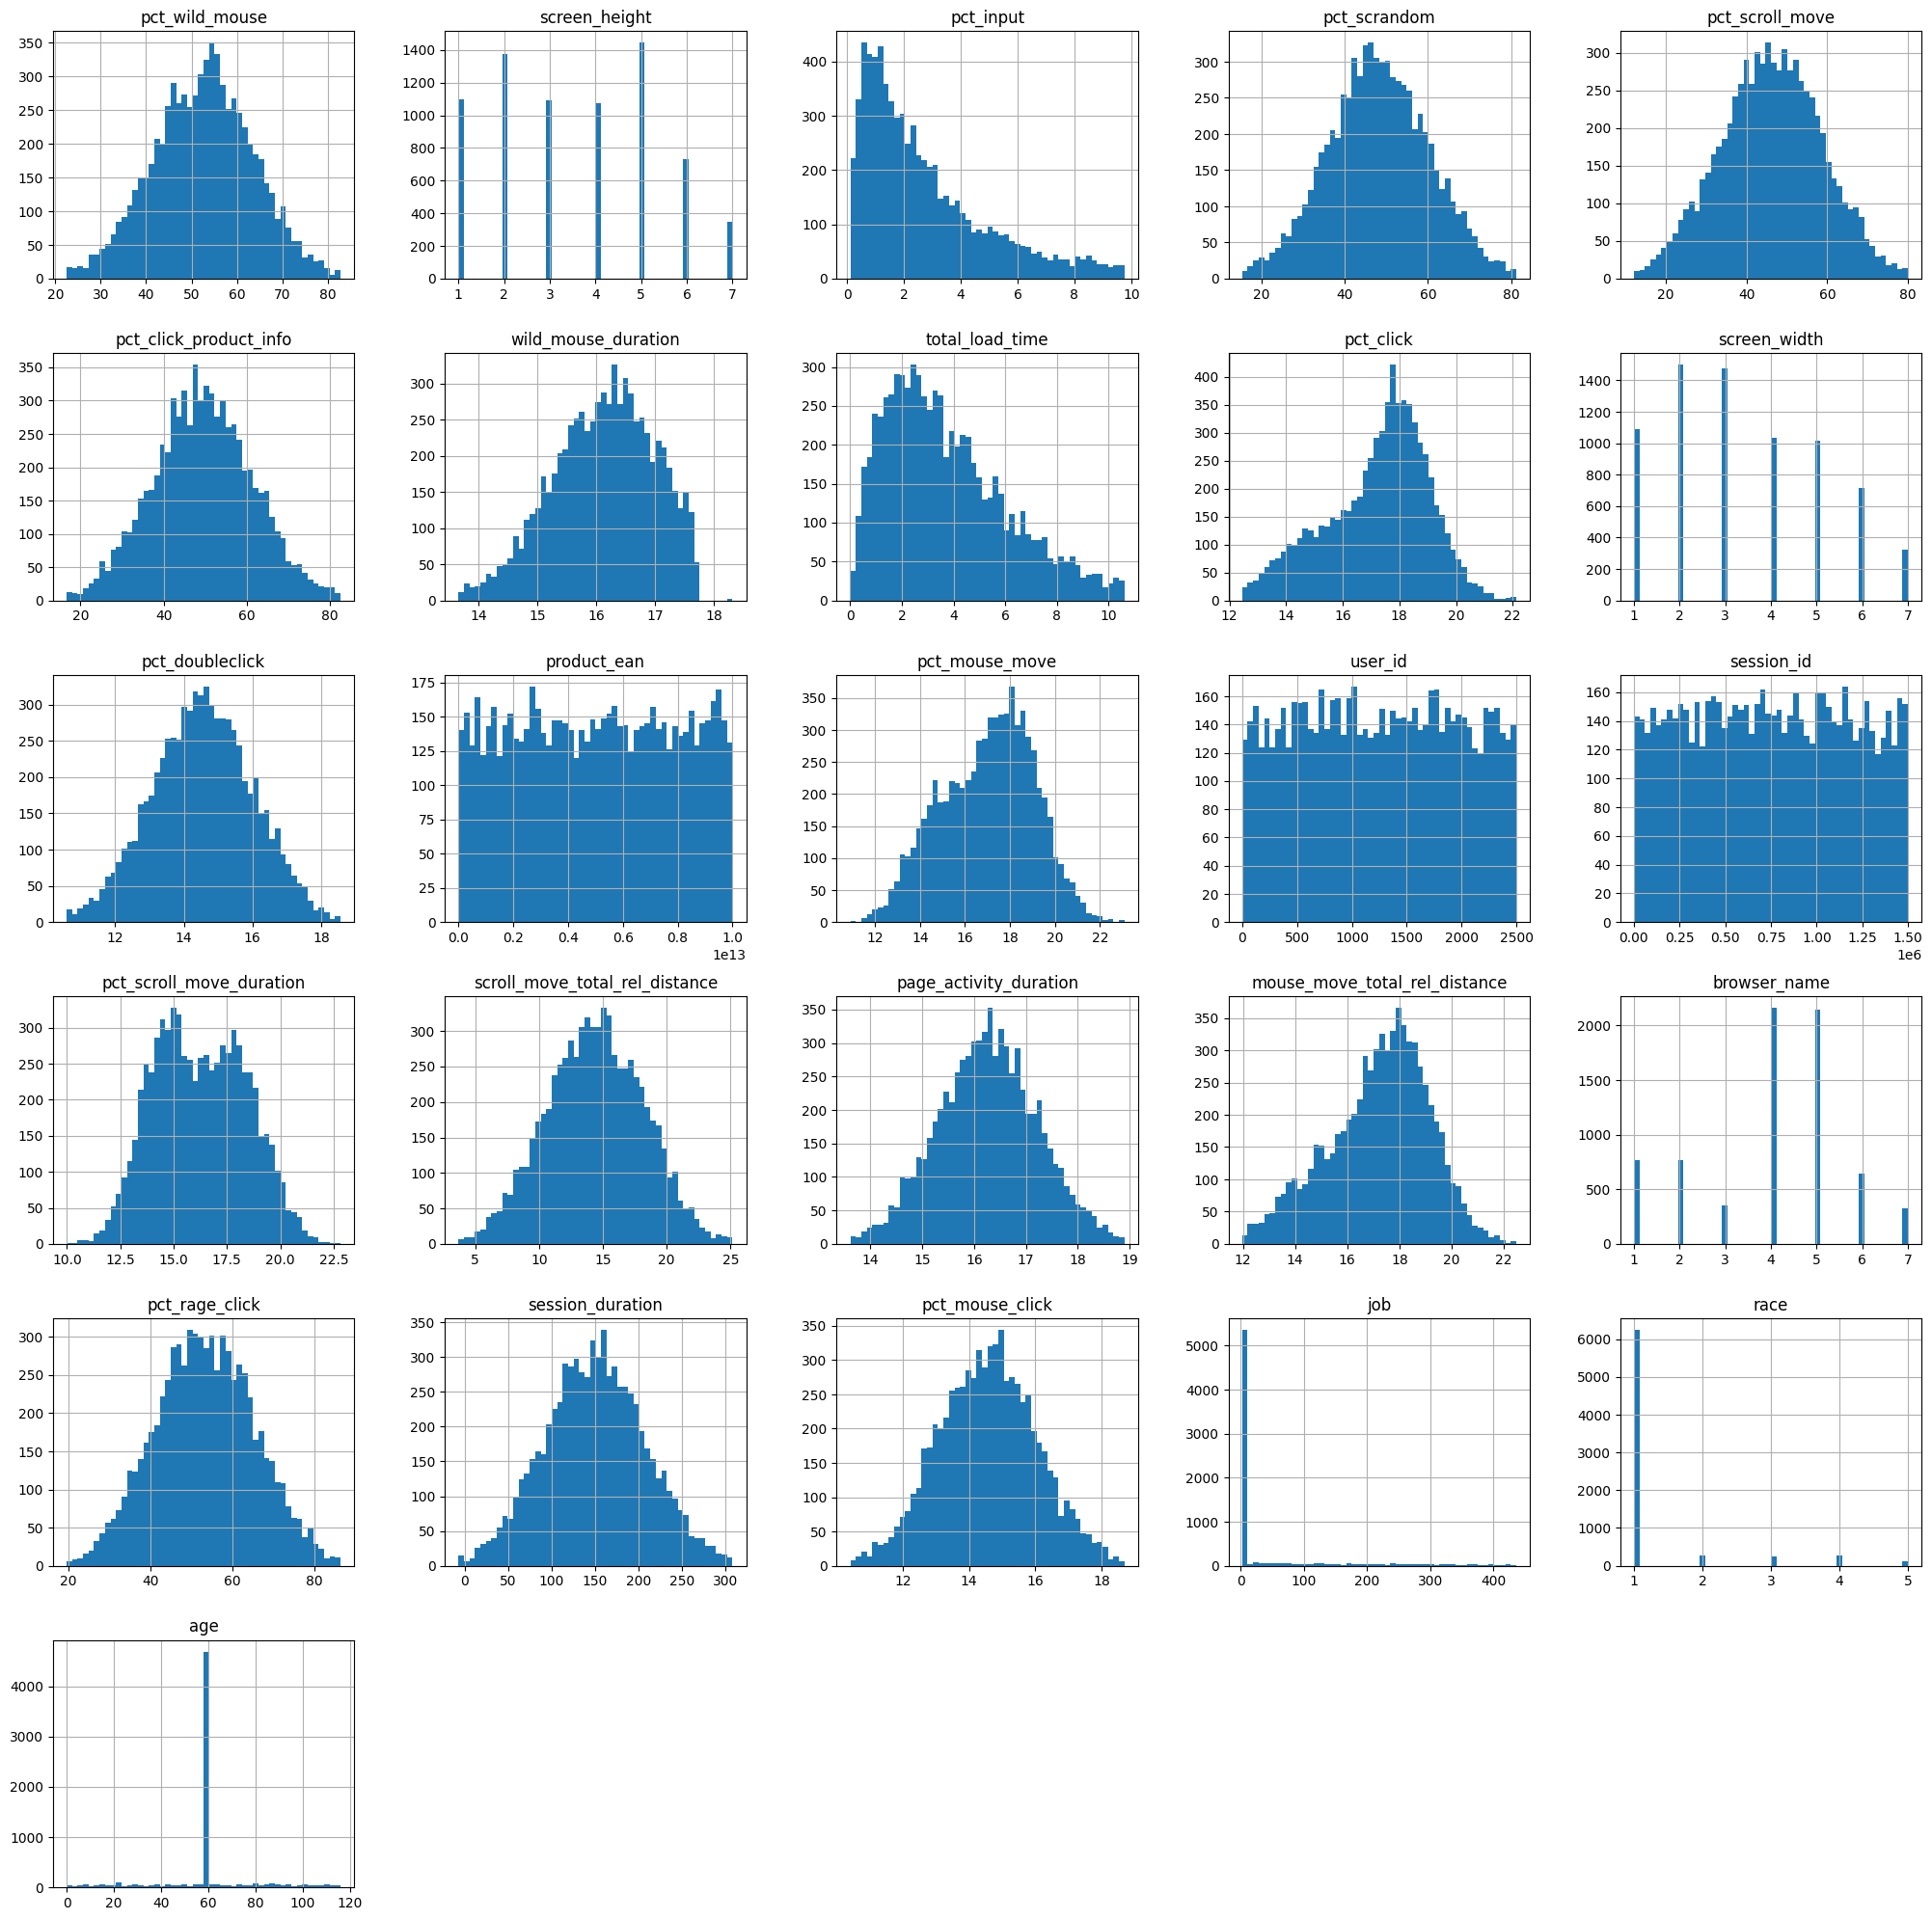

In [31]:
scaler = MinMaxScaler()
X_train.hist(figsize=(25,25), bins=50)
X_scaled = scaler.fit_transform(X_train) 
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)

Na týchto histogramoch môžeme vidieť, ako sú jednotlivé údaje distribuované pred škálovaním.

array([[<Axes: title={'center': 'pct_wild_mouse'}>,
        <Axes: title={'center': 'screen_height'}>,
        <Axes: title={'center': 'pct_input'}>,
        <Axes: title={'center': 'pct_scrandom'}>,
        <Axes: title={'center': 'pct_scroll_move'}>],
       [<Axes: title={'center': 'pct_click_product_info'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'total_load_time'}>,
        <Axes: title={'center': 'pct_click'}>,
        <Axes: title={'center': 'screen_width'}>],
       [<Axes: title={'center': 'pct_doubleclick'}>,
        <Axes: title={'center': 'product_ean'}>,
        <Axes: title={'center': 'pct_mouse_move'}>,
        <Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'session_id'}>],
       [<Axes: title={'center': 'pct_scroll_move_duration'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>,
        <Axes: title={'center': 'mouse_m

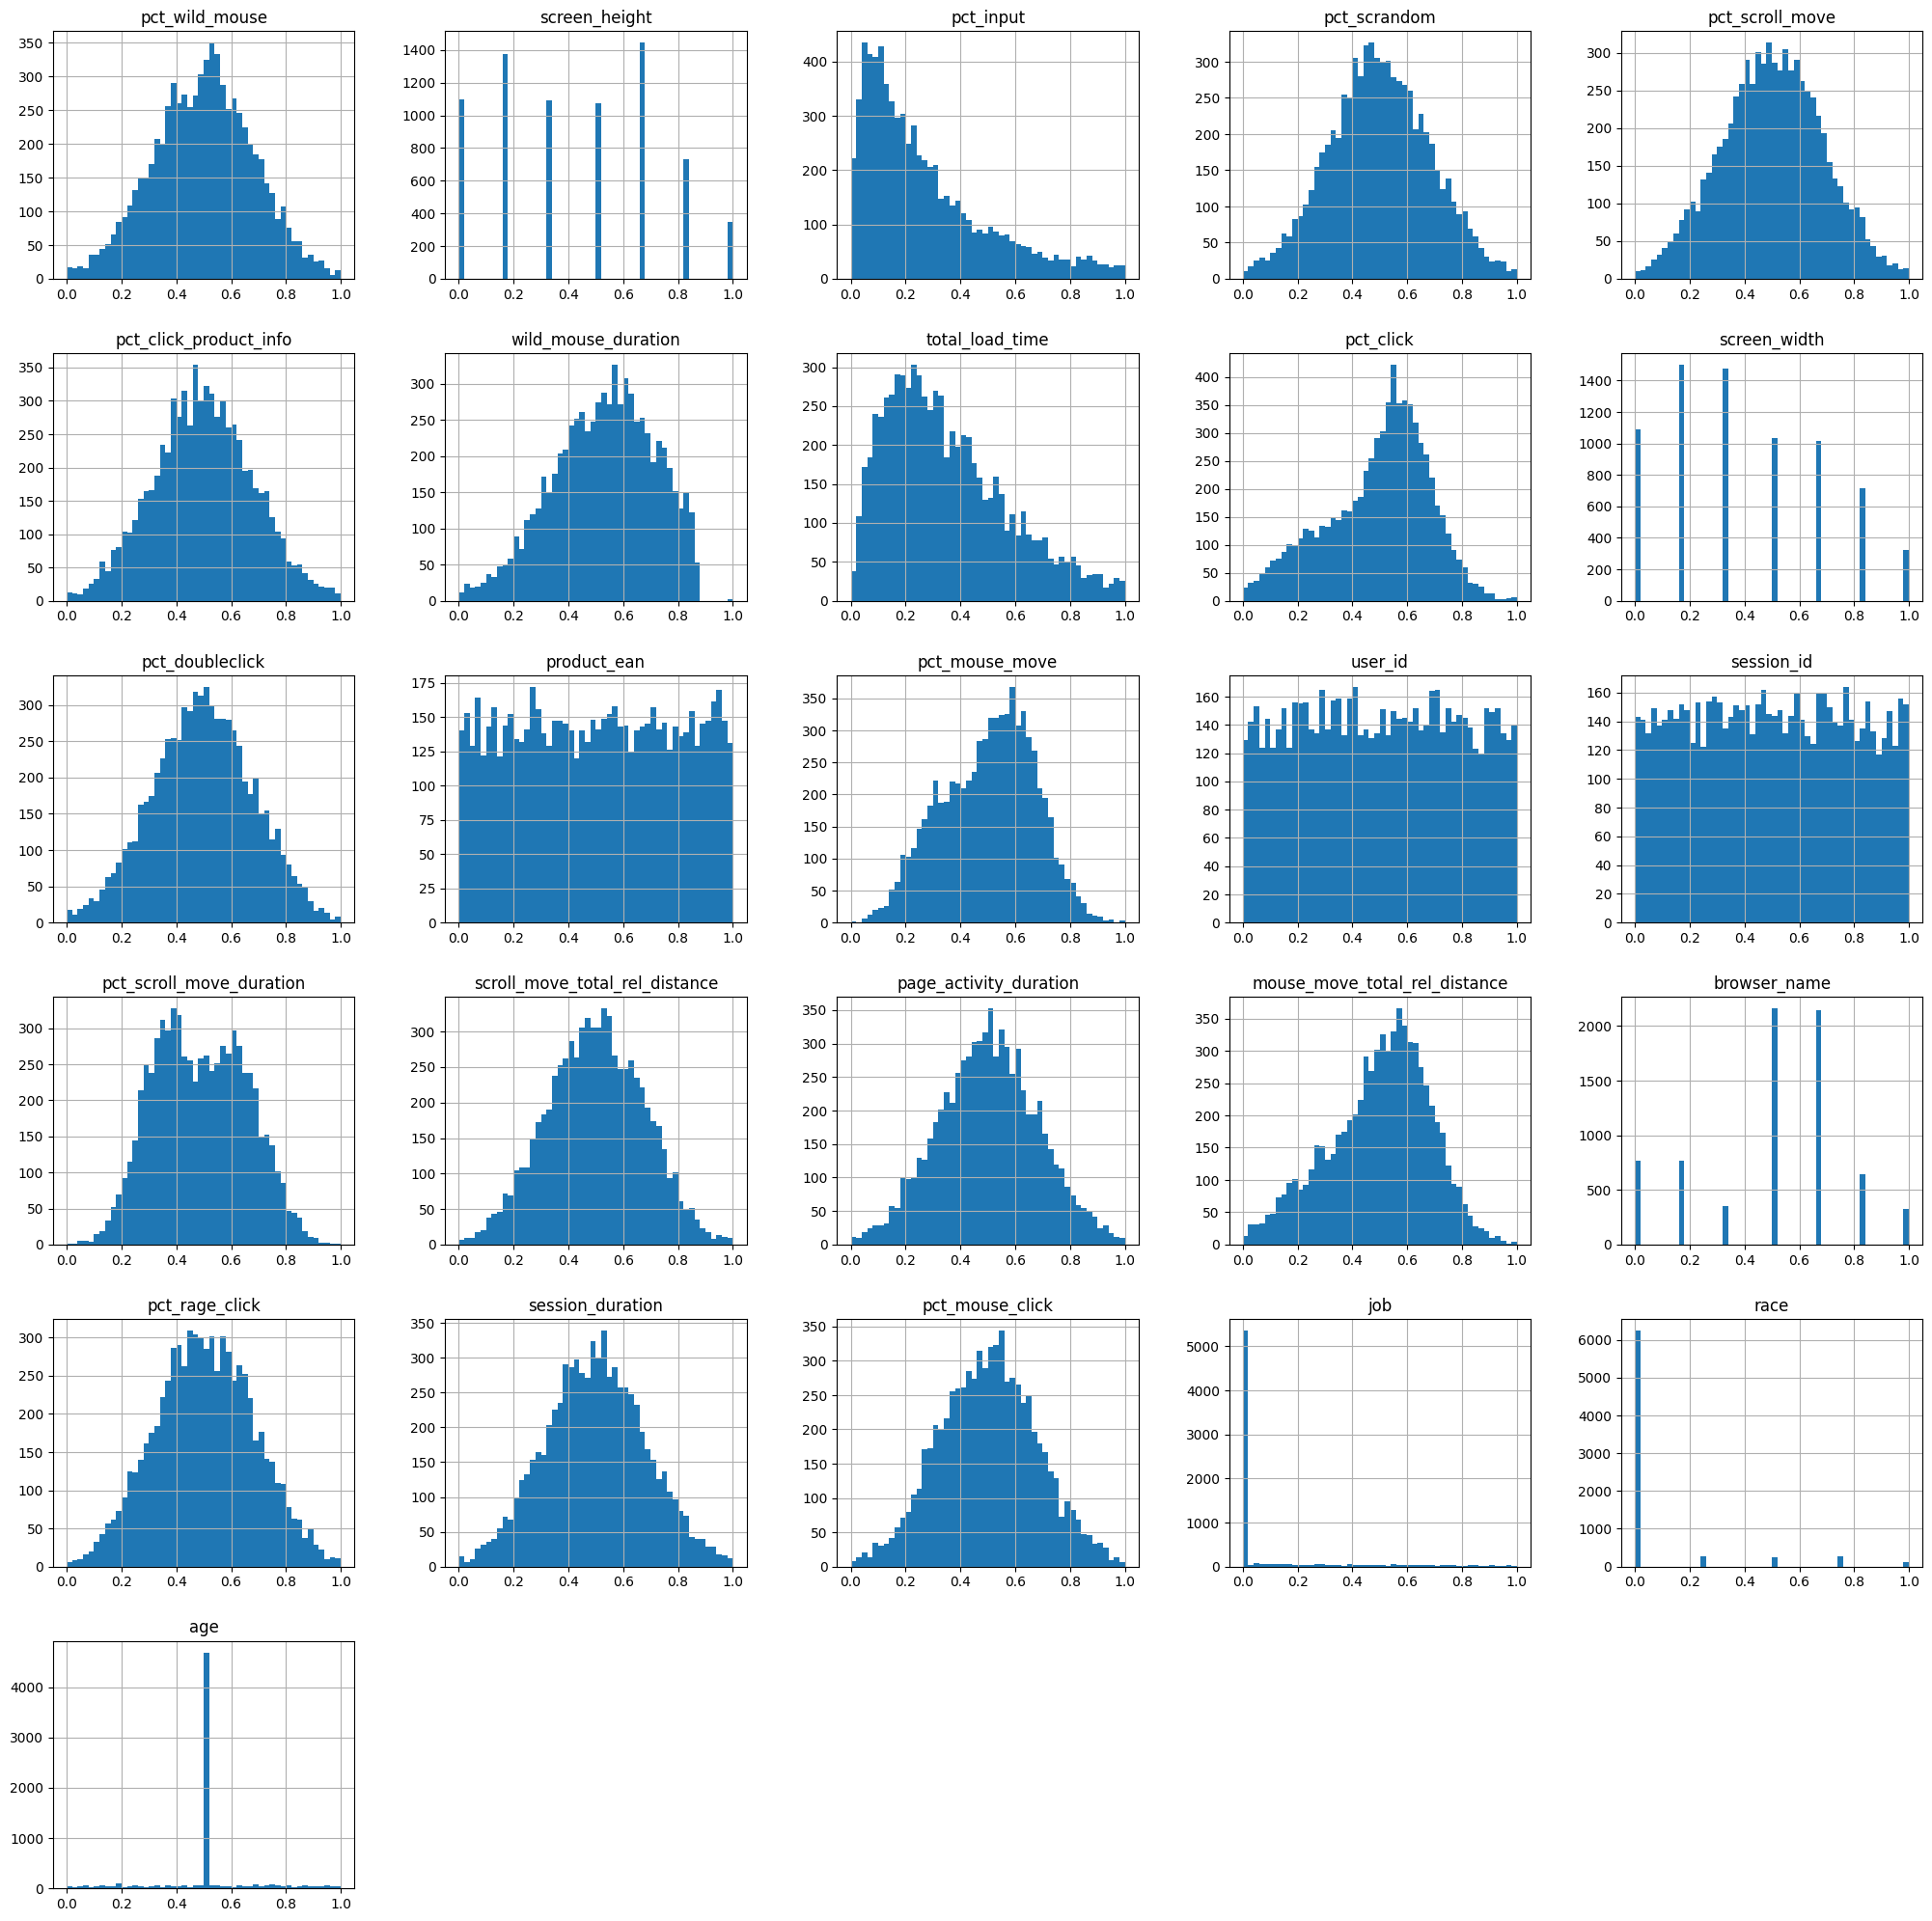

In [32]:
X_scaled.hist(figsize=(25,25), bins=50)

Vidíme, že pri použití MinMaxScaler distribúcia dát nezmenila len ich veľkosť.

### Štandardné škálovanie

Používame štandardné škálovanie, aby sa údaje viac podobali Gaussovcom, ale extrémne hodnoty budú stále pretrvávať, čo bude musieť byť opravené v ďalšom kroku.

array([[<Axes: title={'center': 'pct_wild_mouse'}>,
        <Axes: title={'center': 'screen_height'}>,
        <Axes: title={'center': 'pct_input'}>,
        <Axes: title={'center': 'pct_scrandom'}>,
        <Axes: title={'center': 'pct_scroll_move'}>],
       [<Axes: title={'center': 'pct_click_product_info'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'total_load_time'}>,
        <Axes: title={'center': 'pct_click'}>,
        <Axes: title={'center': 'screen_width'}>],
       [<Axes: title={'center': 'pct_doubleclick'}>,
        <Axes: title={'center': 'product_ean'}>,
        <Axes: title={'center': 'pct_mouse_move'}>,
        <Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'session_id'}>],
       [<Axes: title={'center': 'pct_scroll_move_duration'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>,
        <Axes: title={'center': 'mouse_m

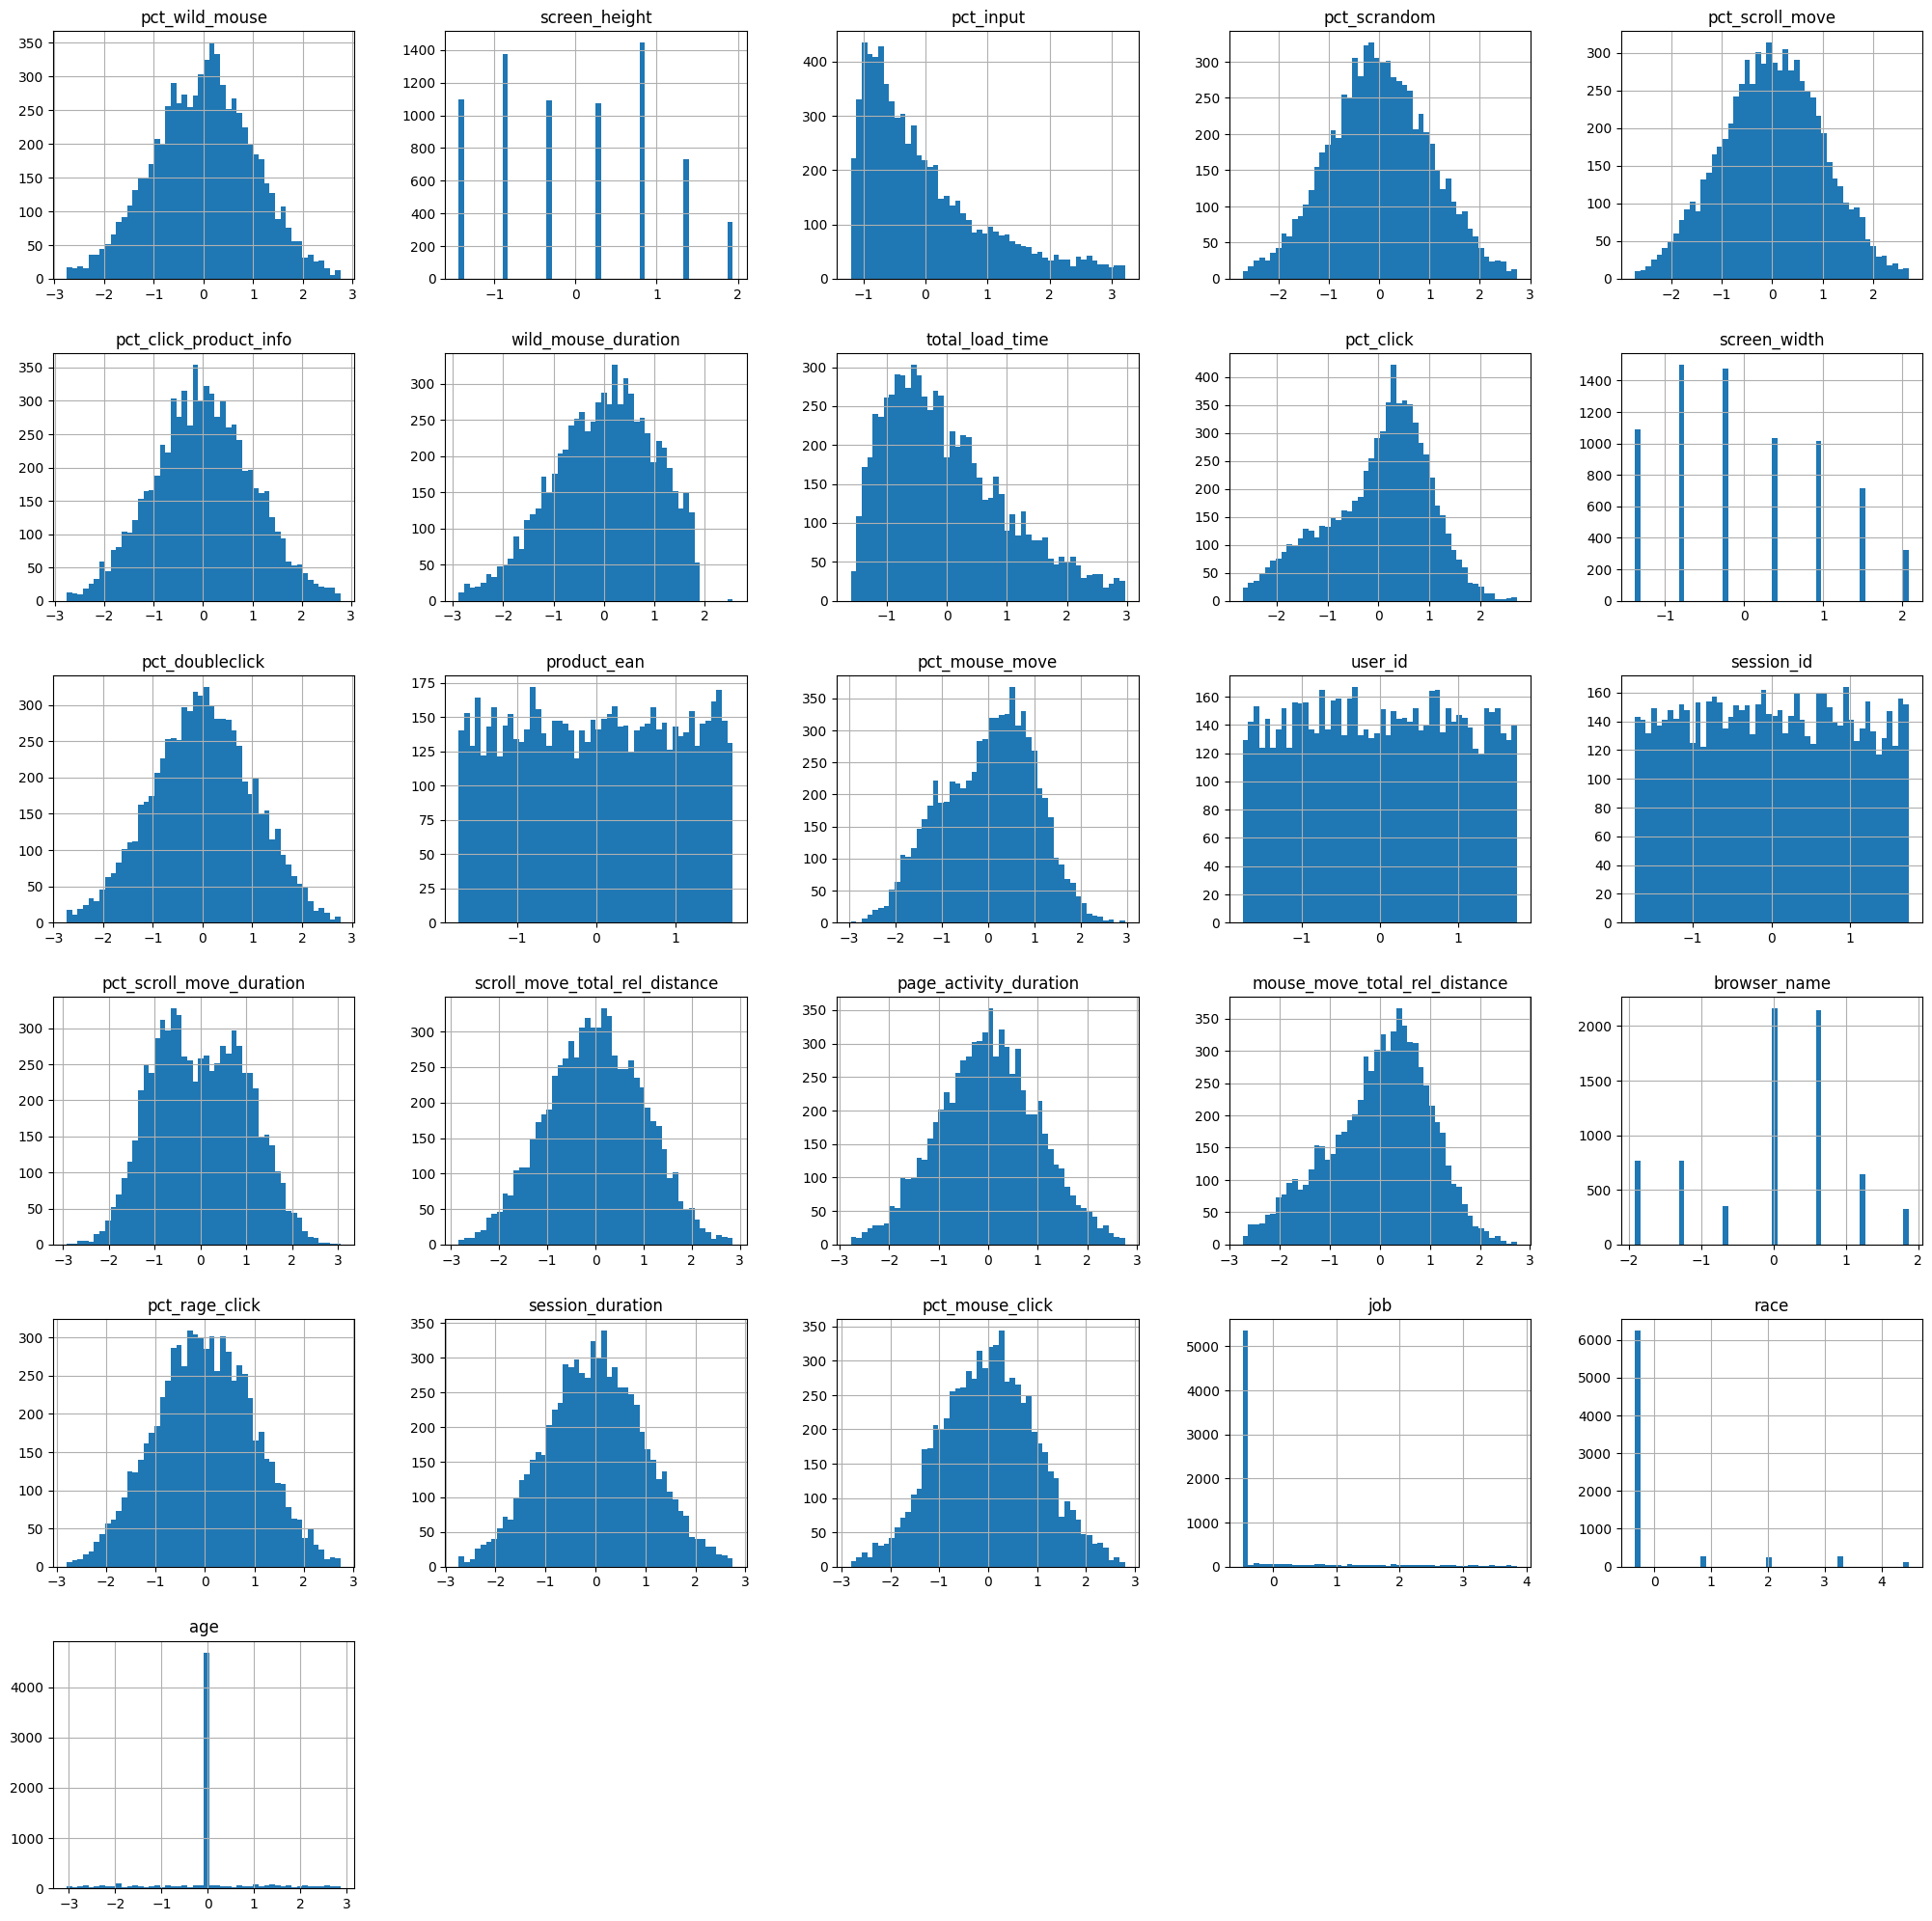

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)
X_scaled.hist(figsize=(25,25), bins=50)

Po použití StandardScaling vidíme graf, že priemer údajov je viac vycentrovaný, ale distribúcia je stále zachovaná.

### Normálizovanie distribúcia údajov

Normalizácia pomocou PowerTransformer zaisťuje, že transformované údaje sú následne škálované tak, aby mali nulový priemer a jednotkový rozptyl a tiež aby boli naše údaje viac gaussovské.

array([[<Axes: title={'center': 'pct_wild_mouse'}>,
        <Axes: title={'center': 'screen_height'}>,
        <Axes: title={'center': 'pct_input'}>,
        <Axes: title={'center': 'pct_scrandom'}>,
        <Axes: title={'center': 'pct_scroll_move'}>],
       [<Axes: title={'center': 'pct_click_product_info'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'total_load_time'}>,
        <Axes: title={'center': 'pct_click'}>,
        <Axes: title={'center': 'screen_width'}>],
       [<Axes: title={'center': 'pct_doubleclick'}>,
        <Axes: title={'center': 'product_ean'}>,
        <Axes: title={'center': 'pct_mouse_move'}>,
        <Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'session_id'}>],
       [<Axes: title={'center': 'pct_scroll_move_duration'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>,
        <Axes: title={'center': 'mouse_m

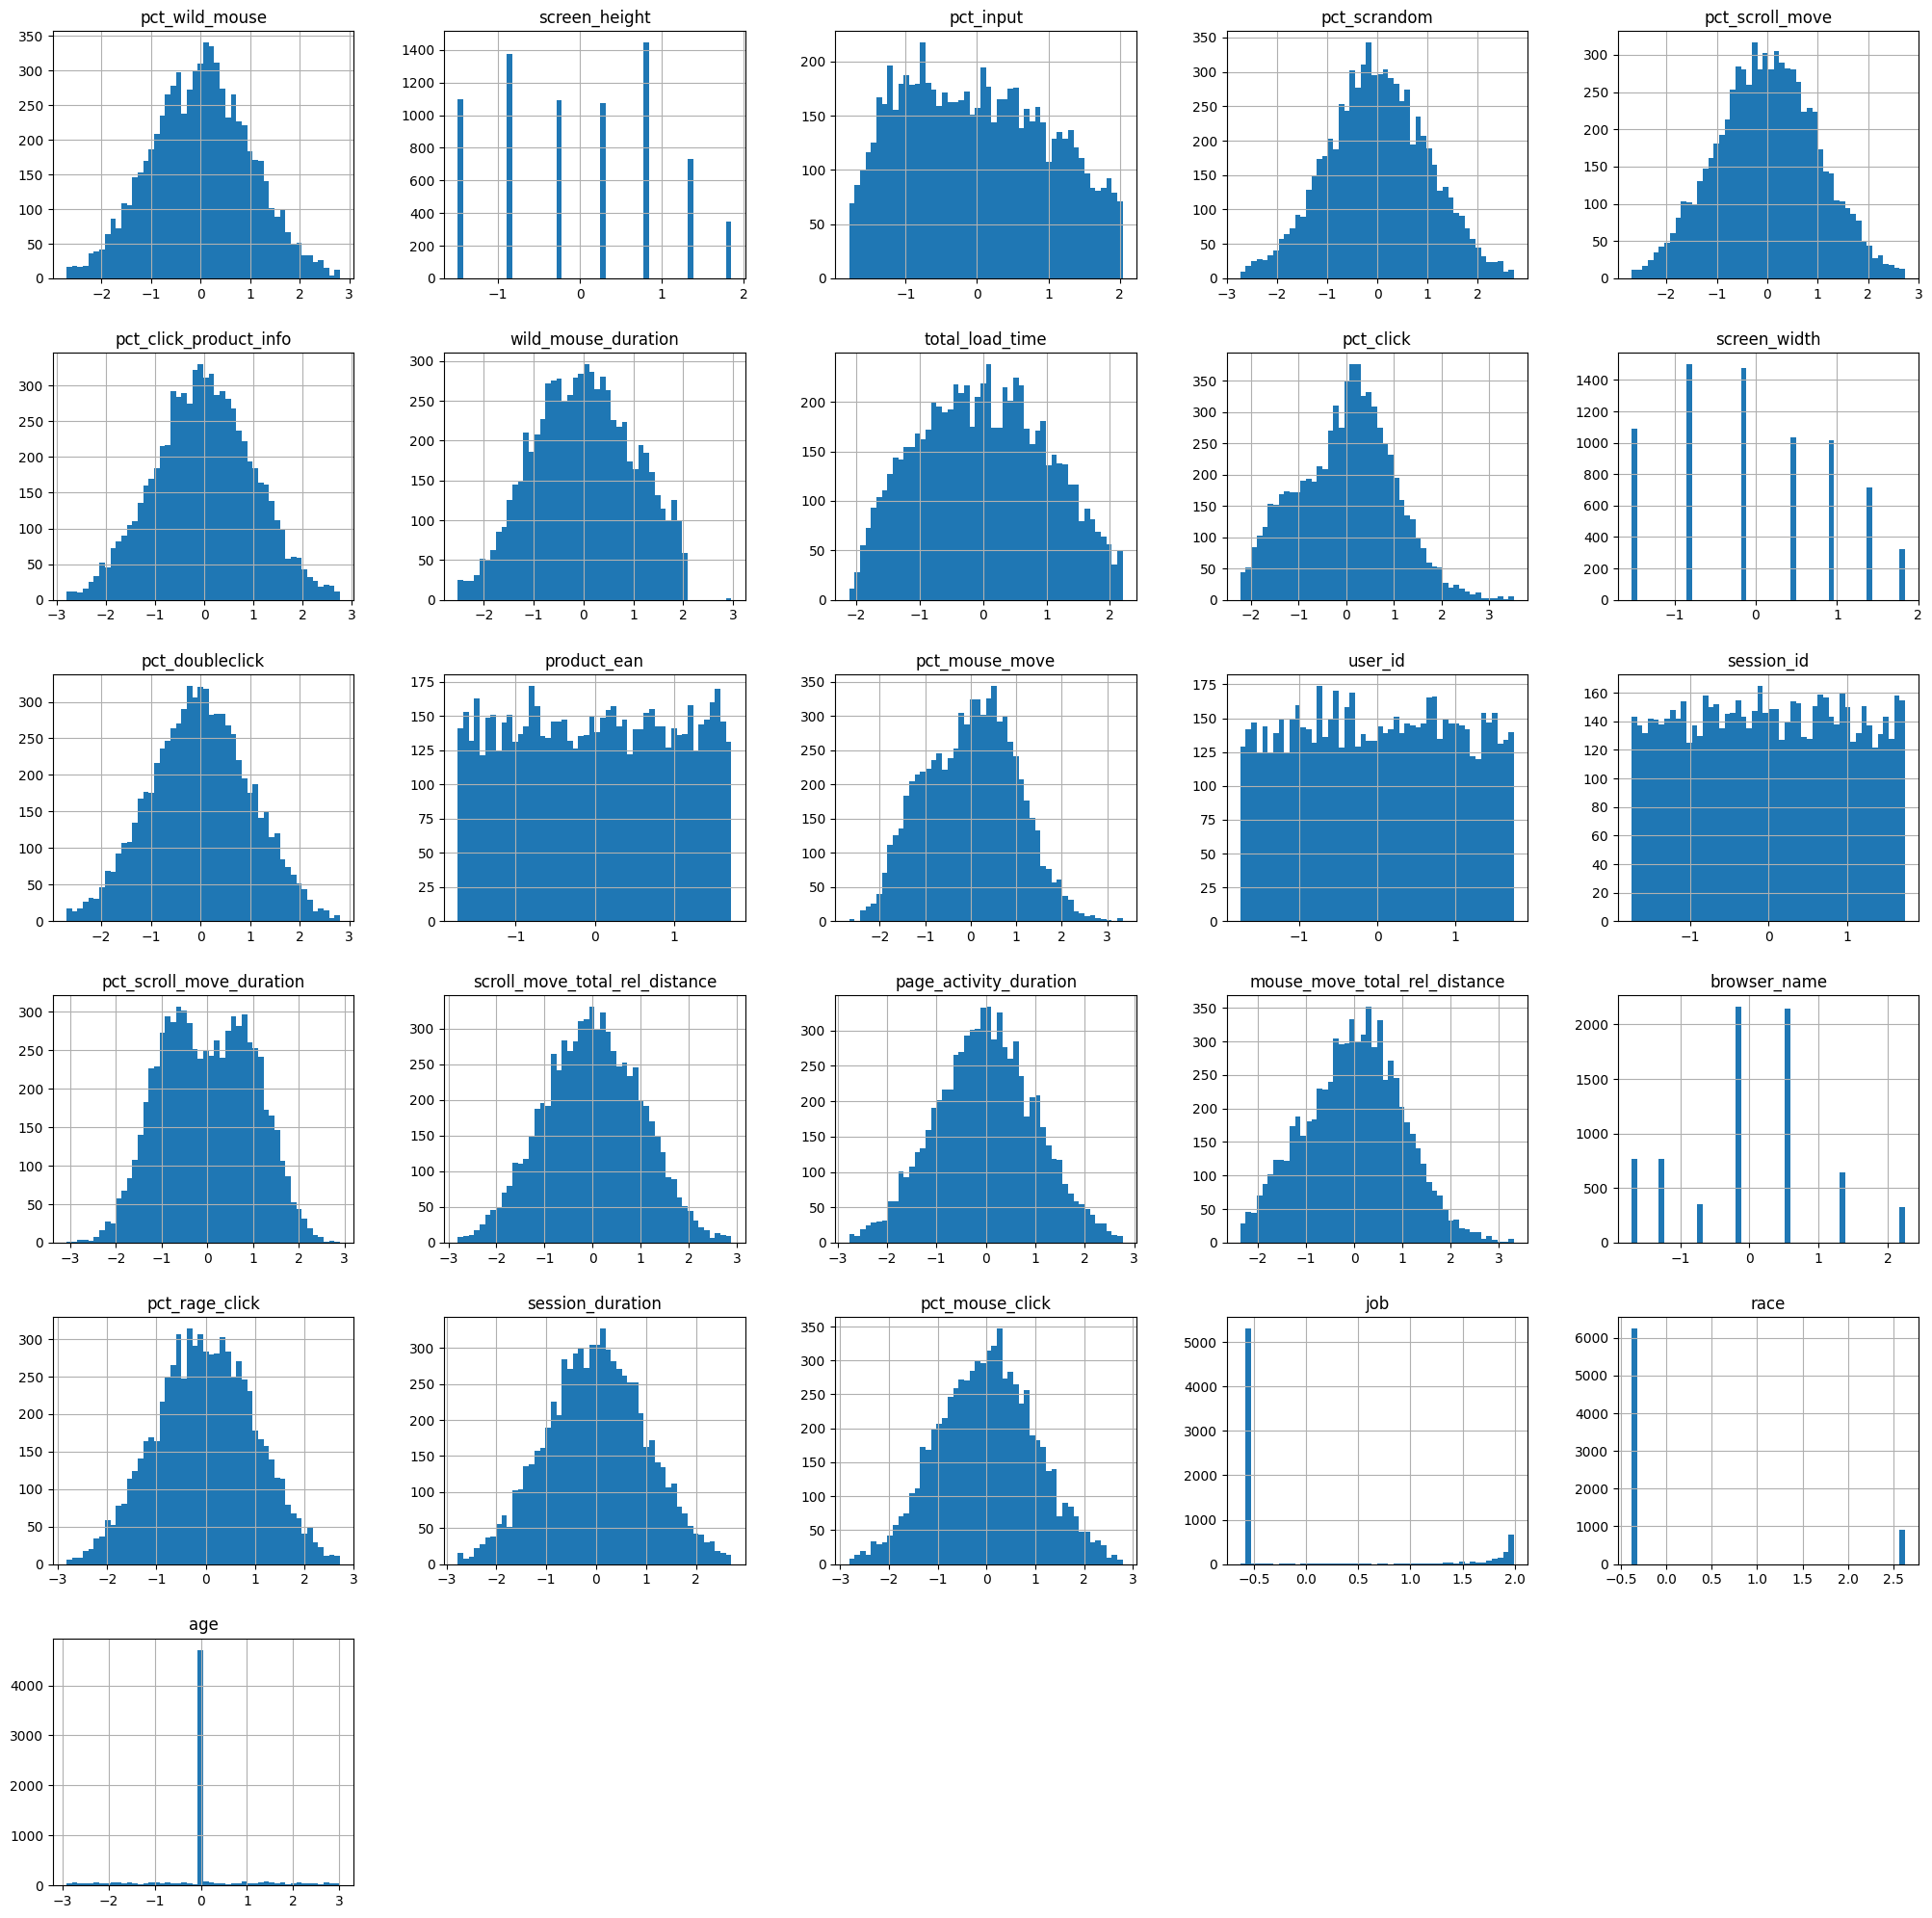

In [34]:
power = PowerTransformer(method='yeo-johnson', standardize=True) 
X_new = power.fit_transform(X_scaled)
X_new = pd.DataFrame(X_new, columns=X_train.columns)
X_new.hist(figsize=(25,25), bins=50)

Na grafe vidíme, že na strane sú veľké extrémne hodnoty, chceme naše dáta zjednotiť pomocou PowerTransformaer a yeo-johnsonovej metódy. Vďaka tomu bude distribúcia našich údajov gaussovskejšia. Ako vidíme, takmer všetky naše údaje začínajú vyzerať ako gaussovská krivka.

### Quantile transformer

Pomocou kvantilového transformátora transformujeme vlastnosti tak, aby sledovali rovnomernejšie a normálnejšie rozloženie.

array([[<Axes: title={'center': 'pct_wild_mouse'}>,
        <Axes: title={'center': 'screen_height'}>,
        <Axes: title={'center': 'pct_input'}>,
        <Axes: title={'center': 'pct_scrandom'}>,
        <Axes: title={'center': 'pct_scroll_move'}>],
       [<Axes: title={'center': 'pct_click_product_info'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'total_load_time'}>,
        <Axes: title={'center': 'pct_click'}>,
        <Axes: title={'center': 'screen_width'}>],
       [<Axes: title={'center': 'pct_doubleclick'}>,
        <Axes: title={'center': 'product_ean'}>,
        <Axes: title={'center': 'pct_mouse_move'}>,
        <Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'session_id'}>],
       [<Axes: title={'center': 'pct_scroll_move_duration'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>,
        <Axes: title={'center': 'mouse_m

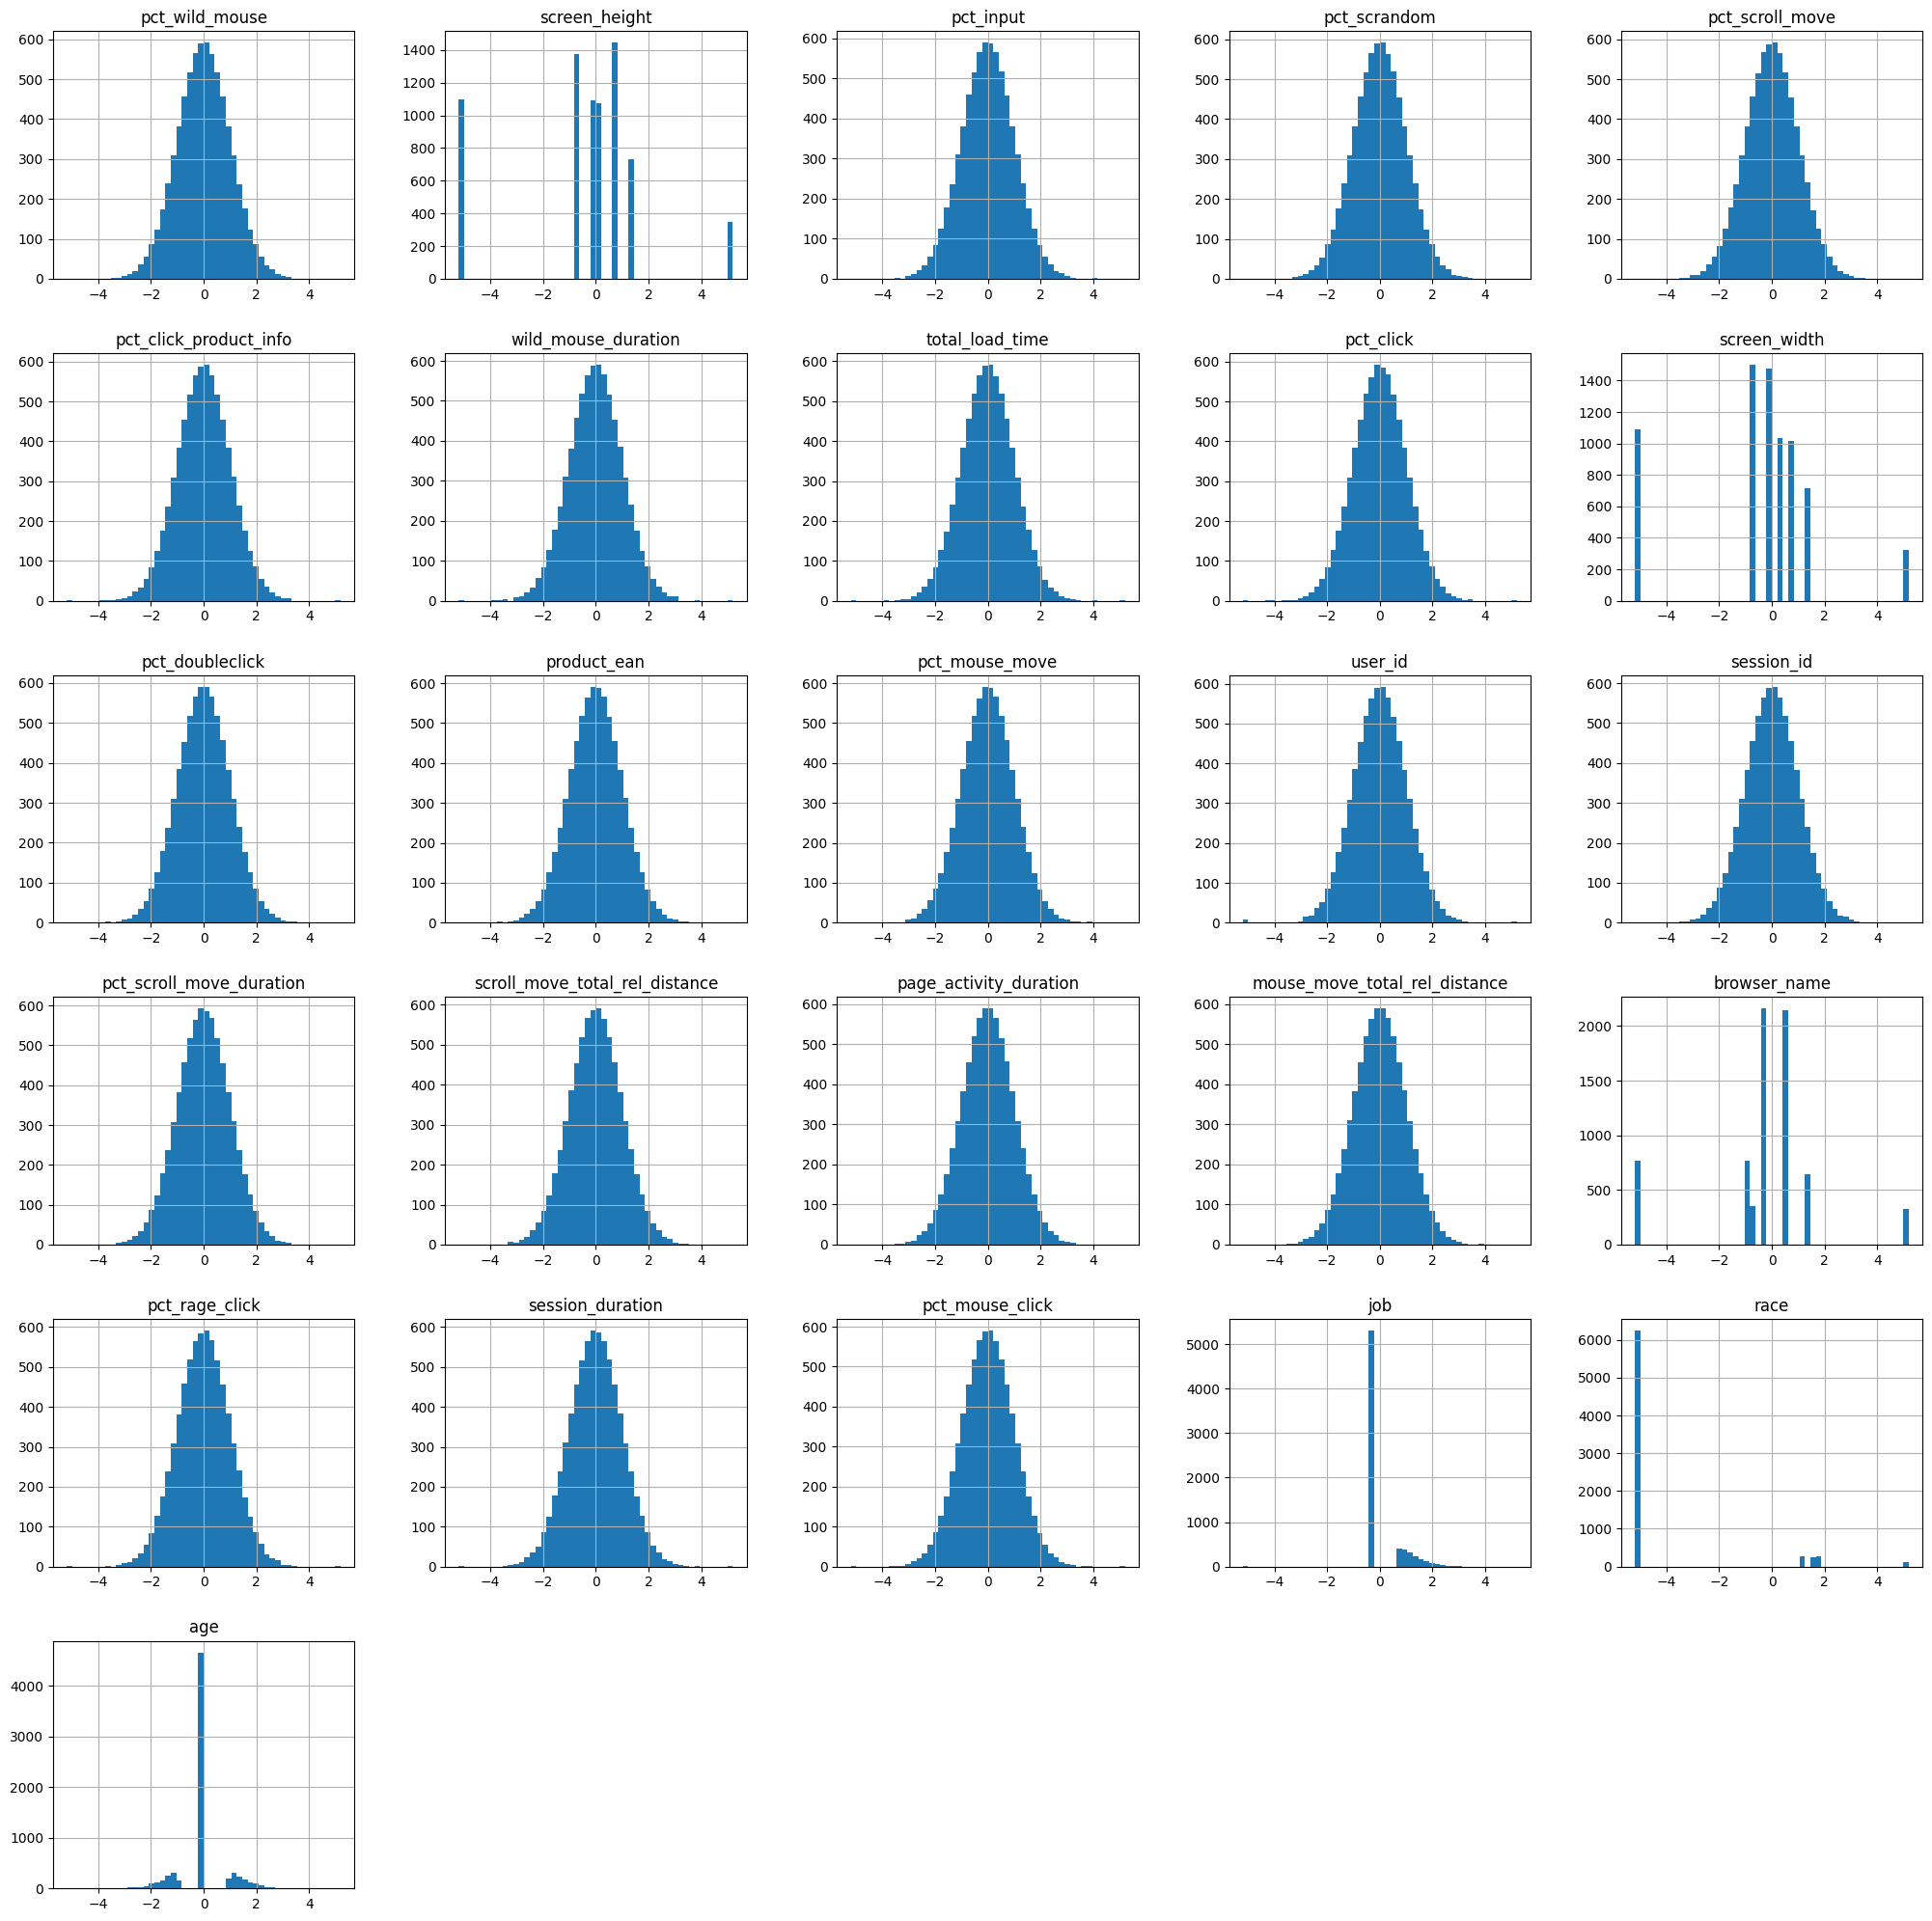

In [35]:
quantile = QuantileTransformer(output_distribution='normal')
X_new = quantile.fit_transform(X_new)
X_new = pd.DataFrame(X_new, columns=X_train.columns)
X_new.hist(figsize=(25,25), bins=50)

Ako vidíme na histogramoch, takmer všetky údaje sú ako gaussovské, to znamená, že existuje malý alebo žiadny rozdiel v distribúcii každého prvku.

### Feature selection

In [36]:
transform = SelectKBest(mutual_info_regression, k=10)
transform.fit_transform( X_new, y_train)
result=pd.DataFrame({'column_name':X_train.columns, 'column_score':transform.scores_})
result.sort_values('column_score', ascending=False).head(10)

,column_name,column_score
18,mouse_move_total_rel_distance,0.129600
8,pct_click,0.127032
12,pct_mouse_move,0.111005
16,scroll_move_total_rel_distance,0.021432
24,race,0.011954
22,pct_mouse_click,0.005998
20,pct_rage_click,0.004960
10,pct_doubleclick,0.004756
1,screen_height,0.002880
15,pct_scroll_move_duration,0.002324


Podľa výsledkov môžeme vidieť, že prvé 3 atribúty majú omnoho vyššie skore ako ostatné, štvrtý má tiež vyššie oproti ostatným, ale porovnateľne nižsie ako spomínané 3 atribúty

In [37]:
transform2 = SelectKBest(f_regression, k=10)
transform2.fit_transform( X_new, y_train)
result2=pd.DataFrame({'column_name':X_train.columns, 'column_score':transform2.scores_})
result2.sort_values('column_score', ascending=False).head(10)

,column_name,column_score
8,pct_click,1190.361304
18,mouse_move_total_rel_distance,1022.247206
12,pct_mouse_move,990.828796
16,scroll_move_total_rel_distance,29.054733
22,pct_mouse_click,10.459321
21,session_duration,6.683971
10,pct_doubleclick,3.004692
4,pct_scroll_move,2.673579
14,session_id,2.397047
7,total_load_time,2.310083


Podľa výsledkov môžeme vidieť, že prvé 3 atribúty majú omnoho vyššie skore ako ostatné, štvrtý má tiež vyššie oproti ostatným, ale porovnateľne nižsie ako spomínané 3 atribúty

In [38]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit( X_new, y_train)
selector = SelectFromModel(estimator=lsvc, prefit=True)
pd.DataFrame({'attr':X_train.columns, 'score':lsvc.coef_[0]}).sort_values('score', ascending=False).head(10)

,attr,score
8,pct_click,0.418615
15,pct_scroll_move_duration,0.411564
22,pct_mouse_click,0.203177
18,mouse_move_total_rel_distance,0.158253
10,pct_doubleclick,0.116819
4,pct_scroll_move,0.014292
21,session_duration,0.012521
14,session_id,0.002093
11,product_ean,0.000000
16,scroll_move_total_rel_distance,0.000000


Podľa výsledkov môžeme vidieť, že prvé 2 atribúty majú omnoho vyššie skore ako ostatné, tretí, štvrtý a piaty má tiež vyššie oproti ostatným, ale porovnateľne nižsie ako spomínané 2 atribúty

In [39]:
selector = SelectFromModel(estimator=LogisticRegression()).fit( X_new, y_train)
result3=pd.DataFrame({'column_name':X_train.columns, 'column_score':selector.estimator_.coef_[0]})
result3.sort_values('column_score', ascending=False).head(10)

,column_name,column_score
8,pct_click,1.474562
22,pct_mouse_click,0.892103
15,pct_scroll_move_duration,0.876474
10,pct_doubleclick,0.643677
18,mouse_move_total_rel_distance,0.545506
2,pct_input,0.153311
4,pct_scroll_move,0.065882
21,session_duration,0.054837
14,session_id,0.021568
20,pct_rage_click,0.016309


Podľa výsledkov môžeme vidieť, že prvé 2 atribúty majú omnoho vyššie skore ako ostatné, tretí, prípadne štvrtý má tiež vyššie oproti ostatným, ale porovnateľne nižsie ako spomínané 2 atribúty

Z výsledkov môžeme vidieť, že najdôležitejšie atribúty sú pct_clic a mouse_move_total_rel_distance, kedže mali vo všetkých výsledkoch výrazne vyššie skore. Do úvahy môžem zobrať aj atribúť scroll_move_total_rel_distance, kedže tiež mal vyššie skore v vačšine testov. Poradie by som určila takéto:
1. pct_clic
2.  mouse_move_total_rel_distance
3.  scroll_move_total_rel_distance

### Predspracovanie pomocou pipelines

Aby sme zrefaktorovali naše spracovanie údajov, najskôr použijeme techniky čistenia údajov, ktoré sme robili predtým. Tieto kroky boli zhrnuté vo funkcii data_correction. Tu odstránime nepotrebné duplikáty používateľov a sessions, vypočítame vek používateľov, kódovanie stĺpcov a vynechanie nepotrebných stĺpcov.

Vytvorenie pipelinu pozostáva zo štyroch krokov:
- Handlovanie outlierov:<br>
Táto funkcia umožňuje rôzne stratégie na správu odľahlých hodnôt v množine údajov.
  - Ak je outlier_handling nastavené na 'remove', používa metódu Local Outlier Factor na identifikáciu a odstránenie odľahlých hodnôt z číselných stĺpcov.
  - Ak je nastavené na 'quantile', použije sa vlastná metóda delete_outliers_quantile (nie je definovaná v úryvku), pravdepodobne na spracovanie odľahlých hodnôt na základe kvantilových prahov.
  - Možnosť 'keep' ponecháva odľahlé hodnoty nedotknuté.
<br>
- Konfigurácia imputera:<br>
Funkcia skontroluje platné hodnoty imputer_type ('priemer', 'medián' alebo 'najčastejšie') a vyvolá chybu pre neplatné vstupy.
Konfiguruje imputer na doplnenie chýbajúcich hodnôt podľa zadanej stratégie.

- Kódovanie kategorických stĺpcov:<br>
Ak má hodnota encode_categorical_columns hodnotu True, funkcia použije jednorazové kódovanie na kategorické stĺpce.
Toto je ďalej spresnené, ak je špecifikovaný only_columns, čím sa zabezpečí, že kódovanie sa použije iba na určené stĺpce.

- Configuracia pipelinu: <br>
Funkcia vytvára objekt Pipeline, pričom postupne pridáva kroky pre jednorazové kódovanie (podmienené), imputáciu, škálovanie (pomocou MinMaxScaler), štandardizáciu (pomocou StandardScaler),  PowerTransformer a kvantilovú transformáciu (pomocou QuantileTransformer).

In [40]:
products = pd.read_csv("data/product.csv", sep='\t')
sessions = pd.read_csv("data/session.csv", sep='\t')
users = pd.read_csv("data/user.csv", sep='\t')

users = users.drop_duplicates(subset='user_id', keep='first')
users['race'] = users['race'].fillna('unspecified')
users['birthdate'] = pd.to_datetime(users['birthdate'], errors='coerce')
sessions['ack']=sessions['ack'].astype(int)
duplikatne_riadky = sessions[sessions.duplicated()]
sessions.drop_duplicates(inplace=True)
sessions['session_start'] = pd.to_datetime(sessions['session_start'], errors='coerce')

merged_data = pd.merge(sessions, users, on='user_id', how='left')


def data_correction(merged_data):
    merged_data['age'] = ((datetime.now() - merged_data['birthdate']).dt.days / 365.25)
    merged_data['age'] = merged_data['age'].round()
    mean_age = merged_data['age'].mean()
    merged_data['age'].fillna(mean_age, inplace=True)
    merged_data['age'] = merged_data['age'].round().astype(int)

    if 'username' in merged_data.columns:
        merged_data.drop('username', axis='columns', inplace=True)
    if 'residence' in merged_data.columns:
        merged_data.drop('residence', axis='columns', inplace=True)
    if 'current_location' in merged_data.columns:
        merged_data.drop('current_location', axis='columns', inplace=True)
    if 'name' in merged_data.columns:
        merged_data.drop('name', axis='columns', inplace=True)
    if 'mail' in merged_data.columns:
        merged_data.drop('mail', axis='columns', inplace=True)
    if 'address' in merged_data.columns:
        merged_data.drop('address', axis='columns', inplace=True)
    if 'birthdate' in merged_data.columns:
        merged_data.drop('birthdate', axis='columns', inplace=True)
    if 'session_start' in merged_data.columns:
        merged_data.drop('session_start', axis='columns', inplace=True)
    if 'sex' in merged_data.columns:
        merged_data.drop('sex', axis='columns', inplace=True)

    merged_data['race'] = merged_data['race'].fillna('unspecified')
    merged_data['job'] = merged_data['job'].fillna('unspecified')
    merged_data=replaceNaNmedian(merged_data)

    ce_ordinal = ce.OrdinalEncoder(cols=['race'])
    merged_data= ce_ordinal.fit_transform(merged_data)
    ce_ordinal = ce.OrdinalEncoder(cols=['job'])
    merged_data= ce_ordinal.fit_transform(merged_data)
    ce_ordinal = ce.OrdinalEncoder(cols=['browser_name'])
    merged_data= ce_ordinal.fit_transform(merged_data)
    ce_ordinal = ce.OrdinalEncoder(cols=['screen_height'])
    merged_data= ce_ordinal.fit_transform(merged_data)
    ce_ordinal = ce.OrdinalEncoder(cols=['screen_width'])
    merged_data= ce_ordinal.fit_transform(merged_data)

    return merged_data

merged_data = data_correction(merged_data)

def create_preprocessor(outlier_handling, imputer_type, encode_categorical_columns, only_columns, data):
    
    # Outlier detection
    if outlier_handling == 'remove':
        lof = LocalOutlierFactor()
        outliers = lof.fit_predict(data.select_dtypes(include=['number']))
        data = data[outliers != -1]
        if only_columns is not None:
            data = data[outliers != -1]
            data = data[only_columns]
    elif outlier_handling == 'keep':
        pass
    elif outlier_handling == 'quantile':
        data = delete_outliers_quantile(data)

    # Imputer configuration
    if imputer_type not in ['mean', 'median', 'most_frequent']:
        raise ValueError("Invalid imputer_type value. Use 'mean', 'median', or 'most_frequent'.")

    pipeline = Pipeline(steps=[])

    if encode_categorical_columns:
        columns = data.select_dtypes(include=['object']).columns
        if only_columns is not None:
            for column in columns:
                if column not in only_columns:
                    columns = columns.drop(column)

        pipeline.steps.append(('onehot', ColumnTransformer([("onehot", OneHotEncoder(), make_column_selector(dtype_include='object'))], remainder='passthrough')))
      
    
    pipeline.steps.append(('imputer', SimpleImputer(strategy=imputer_type)))
    pipeline.steps.append(('scaler', MinMaxScaler()))
    pipeline.steps.append(('standard', StandardScaler()))
    pipeline.steps.append(('power', PowerTransformer(method='yeo-johnson', standardize=True)))
    pipeline.steps.append(('quantile', QuantileTransformer(output_distribution='normal')))

    return pipeline

features = merged_data.drop('ack', axis=1)
target = merged_data['ack']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

preprocessor = create_preprocessor('quantile', 'median', True, None, X_test)
X_test
X_encoded = preprocessor.fit_transform(X_test)
y_train


Počet zmenenych hodnôt je 474


8076    1
4560    0
4982    0
4981    1
7492    0
       ..
5734    1
5191    1
5390    0
860     0
7270    1
Name: ack, Length: 8769, dtype: int64

In [41]:
X_train.to_csv('trenovaci.csv', index=False)
y_train.to_csv('trenovaci_target.csv', index=False)